### `Paper` Al Khourdajie, A., Skea, J., & Green, R. (2024). Climate ambition, background scenario or the model? Attribution of the variance of energy-related indicators in global scenarios. Energy and Climate Change, 100126. ISSN 2666-2787. Available at: https://doi.org/10.1016/j.egycc.2024.100126.
### `Version` January 2024 
### `Authors` Alaa Al Khourdajie, Jim Skea, Richard Green

### Script: `Shapley-Owen Regression Analysis and Decomposition Figures`
Code to implement the Shapley-Owen methodolgy and generating the results for both the main body of the paper, as well as the diagnostic analysis presented in Appendix E. 

Figures provided here are the decomposition figures only for the main body of the paper, as well as Figure D.1 (Appendix D), and Figures E.1 - E.6 (Appendix E) 

1. Import libraries and load the data

In [30]:
# Import libraries
import pandas as pd
import numpy as np

import statsmodels.api as sm 
import patsy
from patsy import dmatrices
import re

import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline 

import warnings

In [31]:
# Load the prepared SSPs data
ssps_df = pd.read_csv("../05_data/df_ssps_cleaned.csv")

In [32]:
# dataframe describe
ssps_df.describe()

,Unnamed: 0,year,Primary_Energy,Primary_Energy_Wind,Primary_Energy_Solar,Primary_Energy_Biomass,Primary_Energy_Biomass_w_CCS,Primary_Energy_Hydro,Primary_Energy_Nuclear,Primary_Energy_Geothermal,...,Final_Energy_Gases,Final_Energy_Heat,Final_Energy_Liquids,Final_Energy_Solids,Final_Energy_Solar,Final_Energy_Electrification,Price_Carbon,GDP_PPP,cumulative_emissions,squared_cumulative_emissions
count,1270.00000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1200.000000,1270.000000,1270.000000,790.000000,...,1270.000000,1020.000000,1270.000000,1270.000000,630.000000,1270.000000,1.150000e+03,1270.000000,1270.000000,1.270000e+03
mean,634.50000,2055.000000,754.604110,45.502617,39.094701,110.294196,43.040660,21.047519,34.301396,3.329422,...,82.260698,15.837969,188.541961,67.103284,28.697332,0.345946,4.421554e-01,294.899930,2928.676941,1.175128e+07
std,366.76173,28.734128,233.157638,52.761159,52.287029,75.269297,73.222249,6.991660,37.966531,6.717801,...,43.096969,12.107126,76.567148,34.213986,26.467908,0.144403,1.739960e+00,202.574095,1782.311061,1.358800e+07
min,0.00000,2010.000000,320.039460,0.438500,0.091900,30.491735,0.000000,8.862000,0.000300,0.010000,...,1.006200,0.007765,6.100989,0.311200,0.121414,0.166853,0.000000e+00,64.808103,126.585175,1.602381e+04
25%,317.25000,2030.000000,586.795578,8.530225,3.763900,58.085600,0.000000,15.854228,12.072246,0.360550,...,54.316913,7.722811,145.006528,42.549043,6.075682,0.234879,1.303597e-22,144.812906,1483.215644,2.199929e+06
50%,634.50000,2055.000000,710.327984,26.696415,22.624201,84.666403,2.952582,20.764100,21.396979,0.845350,...,75.042744,12.245000,181.865958,65.556269,23.980082,0.307968,4.066640e-02,247.254192,2750.123960,7.563182e+06
75%,951.75000,2080.000000,858.498625,61.327165,52.348618,141.624925,59.437624,24.599700,39.794963,3.896118,...,102.298580,21.769775,229.511667,90.199245,42.789487,0.429348,2.461900e-01,397.993530,4103.959651,1.684248e+07
max,1269.00000,2100.000000,1824.000000,388.534660,395.800000,477.000000,417.200000,47.630000,251.698000,55.470000,...,281.913000,84.123000,586.378096,243.141000,163.365636,0.902031,3.185248e+01,1034.177000,8236.910903,6.784670e+07


In [33]:
# Data types of the columns in the dataframe
ssps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 51 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        1270 non-null   int64  
 1   model                                             1270 non-null   object 
 2   scenario                                          1270 non-null   object 
 3   year                                              1270 non-null   int64  
 4   rcp                                               1270 non-null   object 
 5   mod_scen_combined                                 1270 non-null   object 
 6   Primary_Energy                                    1270 non-null   float64
 7   Primary_Energy_Wind                               1270 non-null   float64
 8   Primary_Energy_Solar                              1270 non-null   float64
 9   Primary_Energy_Biom

In [34]:
# Reorder SSPs to start with SSP2 such that the combination of AIM/CGE (model) + SSP2 (scenario) 
# is used as the constant in the regressions, as per the analysis of this paper
ssps_df['scenario'] = pd.Categorical(ssps_df['scenario'], ['SSP2', 'SSP1', 'SSP3', 'SSP4', 'SSP5'])
ssps_df.scenario.unique()

['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']
Categories (5, object): ['SSP2', 'SSP1', 'SSP3', 'SSP4', 'SSP5']

In [35]:
# List of all columns
ssps_df.columns.unique()

Index(['Unnamed: 0', 'model', 'scenario', 'year', 'rcp', 'mod_scen_combined',
       'Primary_Energy', 'Primary_Energy_Wind', 'Primary_Energy_Solar',
       'Primary_Energy_Biomass', 'Primary_Energy_Biomass_w_CCS',
       'Primary_Energy_Hydro', 'Primary_Energy_Nuclear',
       'Primary_Energy_Geothermal', 'Primary_Energy_Fossil',
       'Primary_Energy_Fossil_w_CCS', 'Primary_Energy_Fossil_wo_CCS',
       'Primary_Energy_Coal', 'Primary_Energy_Coal_w_CCS',
       'Primary_Energy_Coal_wo_CCS', 'Primary_Energy_Oil',
       'Primary_Energy_Oil_w_CCS', 'Primary_Energy_Oil_wo_CCS',
       'Primary_Energy_Gas', 'Primary_Energy_Gas_w_CCS',
       'Primary_Energy_Gas_wo_CCS', 'Primary_Energy_Non_Biomass_Renewables',
       'Emissions_CO2', 'Emissions_CH4', 'Emissions_N2O',
       'Emissions_Kyoto_Gases', 'Emissions_CO2_Carbon_Capture_and_Storage',
       'Emissions_CO2_Carbon_Capture_and_Storage_Biomass',
       'Emissions_CO2_Fossil_Fuels_and_Industry', 'Emissions_CO2_Land_Use',
       'Fina

In [36]:
# List of dependent variable that are of interest for this analysis
variables = [
       # Primary Energy      
       'Primary_Energy', 
       'Primary_Energy_Wind',
       'Primary_Energy_Solar', 
       'Primary_Energy_Biomass',
       'Primary_Energy_Biomass_w_CCS', 
       'Primary_Energy_Hydro',
       'Primary_Energy_Nuclear', 
       'Primary_Energy_Geothermal', 
       'Primary_Energy_Non_Biomass_Renewables',
       'Primary_Energy_Fossil',
       "Primary_Energy_Fossil_w_CCS",
       "Primary_Energy_Fossil_wo_CCS",
       'Primary_Energy_Coal',
       'Primary_Energy_Coal_w_CCS',
       'Primary_Energy_Coal_wo_CCS',
       'Primary_Energy_Oil',
       'Primary_Energy_Oil_w_CCS',
       'Primary_Energy_Oil_wo_CCS',
       'Primary_Energy_Gas',
       "Primary_Energy_Gas_w_CCS",
       "Primary_Energy_Gas_wo_CCS",

       # Final Energy
       'Final_Energy', 
       'Final_Energy_Electricity', 
       'Final_Energy_Gases',
       'Final_Energy_Heat', 
       'Final_Energy_Liquids', 
       'Final_Energy_Solids',
       'Final_Energy_Hydrogen', 
       'Final_Energy_Solar', 
       'Final_Energy_Industry',
       'Final_Energy_Residential_and_Commercial',
       'Final_Energy_Transportation',
       'Final_Energy_Electrification',
       
       # Emissions
       'Emissions_CO2',
       'Emissions_CH4',
       'Emissions_N2O', 
       'Emissions_Kyoto_Gases',
       'Emissions_CO2_Carbon_Capture_and_Storage',
       'Emissions_CO2_Carbon_Capture_and_Storage_Biomass',
       'Emissions_CO2_Fossil_Fuels_and_Industry', 
       'Emissions_CO2_Land_Use',

       # Economic variables 
       'Price_Carbon',
       'GDP_PPP',
        
       ]

2) Methodology: Shapley-Owen Value Function

In [37]:
### --------------
# Shapley-Owen Value Function
### --------------

### -------------- Overview of the Shapley-Owen decomposition function --------------
# The function below is the Shapley-Owen decomposition function.
# For background on the Shapley-Owen decomposition, see section 2.3 and Appendix A of the paper.
# The function also undertakes additional appraoches to the Shapley-Owen decomposition, as described in Appendix E of the paper.
# --------------

# -------------- Structure of the code --------------
# The function below is structured as follows:
# BLOCK A: Descriptive Stats
# BLOCK B: Regressions
# BLOCK C: Preparation of columns for input in the final table
# BLOCK D: Preparation of columns for plotting
# BLOCK E: Build the table that contains each step of the calculations above
# --------------

# -------------- Inputs --------------
# The function below takes two inputs:
# 1) variable: the dependent variables
# 2) data: the dataframe prepared in script 01
# --------------

# -------------- Code of the Function --------------
def shapley_owen_decomposition (variable, data):
    # An empty table to fill with the calculations later on
    df=[]
    # An array of the decadal years 2020-2100, for the regression loop 
    years = data.year[1:10].unique()
    for i in years:
        # BLOCK A: Descriptive Stats
        # Generate the basic descriptive stats for the dependent variable for each decadal year
        avg=np.average(data[variable].loc[(data['year'] == i)])
        median=np.median(data[variable].loc[(data['year'] == i)])
        StDev=np.std(data[variable].loc[(data['year'] == i)])
        # Generate the 90th percentile for the dependent variable for each decadal year
        percentile_90=np.percentile(data[variable].loc[(data['year'] == i)], 90)
        # Generate the 75th percentile for the dependent variable for each decadal year
        percentile_75=np.percentile(data[variable].loc[(data['year'] == i)], 75)

        # BLOCK B: Regressions 
        # 1) Univariate regression: Ambition
        # Prepare the regression variables
        dmatrices_Amb = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions')
        y, X = dmatrices(
            dmatrices_Amb,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_results = model.fit()
        # 1a) Univariate RCP regression: RCP [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        # Prepare the regression variables
        dmatrices_Amb_rcp = str(variable + ' ~ rcp')
        y, X = dmatrices(
            dmatrices_Amb_rcp,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_results = model.fit()
        # 2) Univariate regression: Scenario
        # Prepare the regression variables
        dmatrices_Scen = str(variable + ' ~ scenario')
        y, X = dmatrices(
            dmatrices_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Scen_results = model.fit()
        # 3) Univariate regression: Model
        # Prepare the regression variables
        dmatrices_Mod = str(variable + ' ~ model')
        y, X = dmatrices(
            dmatrices_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Mod_results = model.fit()
        # 4) Multivariate regression: Climate ambition and scenario
        # Prepare the regression variables
        dmatrices_Amb_Scen = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + scenario')
        y, X = dmatrices(
            dmatrices_Amb_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Scen_results = model.fit()
        # 4a) Multivariate RCP regression: rcp and scenario
        # Prepare the regression variables
        dmatrices_Amb_rcp_Scen = str(variable + ' ~ rcp + scenario')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Scen,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Scen_results = model.fit()
        # 5) Multivariate regression: Climate ambition and model
        # Prepare the regression variables
        dmatrices_Amb_Mod = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + model')
        y, X = dmatrices(
            dmatrices_Amb_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Mod_results = model.fit()
        # 5a) Multivariate RCP regression: Climate ambition and model
        # Prepare the regression variables
        dmatrices_Amb_rcp_Mod = str(variable + ' ~ rcp + model')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Mod_results = model.fit()
        # 6) Multivariate regression: Scenario and model
        # Prepare the regression variables
        dmatrices_Scen_Mod = str(variable + ' ~ scenario + model')
        y, X = dmatrices(
            dmatrices_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Scen_Mod_results = model.fit()
        # 7) Multivariate regression: climate ambition, scenario and model
        # Prepare the regression variables
        dmatrices_Amb_Scen_Mod = str(variable + ' ~ cumulative_emissions + squared_cumulative_emissions + scenario + model')
        y, X = dmatrices(
            dmatrices_Amb_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_Scen_Mod_results = model.fit()
        # 7a) Multivariate RCP regression: climate ambition, scenario and model
        # Prepare the regression variables
        dmatrices_Amb_rcp_Scen_Mod = str(variable + ' ~ rcp + scenario + model')
        y, X = dmatrices(
            dmatrices_Amb_rcp_Scen_Mod,
            data=data.loc[(data['year'] == i)],
            return_type='dataframe'
            )
        # Describe the OLS regression model (dependent and explanatory vars)
        model = sm.OLS(y, X)
        # Fit the regression model, to compute R2 value later
        Amb_rcp_Scen_Mod_results = model.fit()
        
        # BLOCK C: Preparation of columns for input in the final table
        # Step 1: R2 of the regressions:
        R2_Amb =                Amb_results.rsquared
        R2_Amb_rcp =            Amb_rcp_results.rsquared   
        R2_Scen =               Scen_results.rsquared
        R2_Mod =                Mod_results.rsquared

        R2_Amb_Scen =           Amb_Scen_results.rsquared
        R2_Amb_rcp_Scen =       Amb_rcp_Scen_results.rsquared
        R2_Amb_Mod =            Amb_Mod_results.rsquared
        R2_Amb_rcp_Mod =        Amb_rcp_Mod_results.rsquared
        R2_Scen_Mod =           Scen_Mod_results.rsquared

        R2_Amb_Scen_Mod =       Amb_Scen_Mod_results.rsquared
        R2_Amb_rcp_Scen_Mod =   Amb_rcp_Scen_Mod_results.rsquared

        R2_Residual =           1 - R2_Amb_Scen_Mod
        R2_Residual_rcp =       1 - R2_Amb_rcp_Scen_Mod

        # Step 2: Shapley Decomposition
        R2_Amb_Shapley = (
                            (R2_Amb                                     /   3) + \
                            ((R2_Amb_Scen       -       R2_Scen)        /   6) + \
                            ((R2_Amb_Mod        -       R2_Mod)         /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Scen_Mod)    /   3)
                        )
        R2_Scen_Shapley = (
                            (R2_Scen                                     /   3) + \
                            ((R2_Amb_Scen       -       R2_Amb)          /   6) + \
                            ((R2_Scen_Mod       -       R2_Mod)          /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Amb_Mod)      /   3)
                        )
        R2_Mod_Shapley = (
                            (R2_Mod                                      /   3) + \
                            ((R2_Amb_Mod        -       R2_Amb)          /   6) + \
                            ((R2_Scen_Mod       -       R2_Scen)         /   6) + \
                            ((R2_Amb_Scen_Mod   -       R2_Amb_Scen)     /   3)
                        )
        # Sum of Shapley Values
        R2_Amb_Scen_Mod_Shapley = R2_Amb_Shapley + R2_Scen_Shapley + R2_Mod_Shapley

        # The below test must = 0
        Test_R2_Shapley_vs_R2 = R2_Amb_Scen_Mod - R2_Amb_Scen_Mod_Shapley

        # Step 2a: Shapley Decomposition - rcp [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        R2_Amb_Shapley_rcp = (
                            (R2_Amb_rcp                                     /   3) + \
                            ((R2_Amb_rcp_Scen       -       R2_Scen)        /   6) + \
                            ((R2_Amb_rcp_Mod        -       R2_Mod)         /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Scen_Mod)    /   3)
                        )
        R2_Scen_Shapley_rcp = (
                            (R2_Scen                                        /   3) + \
                            ((R2_Amb_rcp_Scen       -       R2_Amb_rcp)     /   6) + \
                            ((R2_Scen_Mod       -       R2_Mod)             /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Amb_rcp_Mod) /   3)
                        )
        R2_Mod_Shapley_rcp = (
                            (R2_Mod                                         /   3) + \
                            ((R2_Amb_rcp_Mod        -       R2_Amb_rcp)     /   6) + \
                            ((R2_Scen_Mod       -       R2_Scen)            /   6) + \
                            ((R2_Amb_rcp_Scen_Mod   -       R2_Amb_rcp_Scen)/   3)
                        )
        # Sum of Shapley Values
        R2_Amb_rcp_Scen_Mod_Shapley = R2_Amb_Shapley_rcp + R2_Scen_Shapley_rcp + R2_Mod_Shapley_rcp

        # The below test must = 0
        Test_R2_Shapley_vs_R2_rcp = R2_Amb_rcp_Scen_Mod - R2_Amb_rcp_Scen_Mod_Shapley

        # Step 3
        # We prepare the following columns which will be used to plot stacked bar charts.
        # These stacked bar chart will show the R2 in the explanatory variables 
        # and the decomposition of this R2 variability by the three effects identified.
        # The decomposition will be illustrated using the stacks in the stacked bar charts. 
        Avg_SD =        (avg - StDev)
        # The heights of individual effects, is the product of *relevant R2 times 2 standard deviation*
        SD2_Amb =                       (2 * StDev * R2_Amb_Shapley)
        SD2_Scen=                       (2 * StDev * R2_Scen_Shapley)
        SD2_Mod =                       (2 * StDev * R2_Mod_Shapley)
        SD2_Resid =                     (2 * StDev * R2_Residual)
        
        # The "if function" in this BLOCK D below checks for negative values of AVG-SD and 
        # provide the input for variables to be plotted. These values below are the ones that are plotted in 
        # the Shapley Decomposition plots.
        if Avg_SD >= 0:
            Plot_Avg_SD = Avg_SD
        else:
            Plot_Avg_SD = 0
        # We also create similar column that does the reverse of the above.
        if Avg_SD < 0:
            Plot_Avg_SD_Surrogate = Avg_SD
        else:
            Plot_Avg_SD_Surrogate = 0 
        
        # The following calculations are to ensure that the 4 SD2 stacks defined above are 
        # centered about the mean
        Low_end = Plot_Avg_SD + Plot_Avg_SD_Surrogate
        High_end = SD2_Amb + SD2_Scen + SD2_Mod + SD2_Resid + Plot_Avg_SD + Plot_Avg_SD_Surrogate
        Length = High_end + Low_end
        Mid_point = Length / 2
        Avg_vs_Mid_point = avg - Mid_point # which must equal to zero in the final table

        # Step 3a [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
        # We prepare the following columns which will be used to plot stacked bar charts.
        # These stacked bar chart will show the R2 in the explanatory variables
        # and the decomposition of this R2 variability by the three effects identified above.
        # The decomposition will be illustrated using the stacks in the stacked bar charts.
        Avg_SD =        (avg - StDev)
        # The heights of individual effects, is the product of *relevant R2 times 2 standard deviation*
        SD2_Amb_rcp =                       (2 * StDev * R2_Amb_Shapley_rcp)
        SD2_Scen_rcp=                       (2 * StDev * R2_Scen_Shapley_rcp)
        SD2_Mod_rcp =                       (2 * StDev * R2_Mod_Shapley_rcp)
        SD2_Resid_rcp =                     (2 * StDev * R2_Residual_rcp)

        # The "if function" in this BLOCK D below checks for negative values of AVG-SD and
        # provide the input for variables to be plotted. These values below are the ones that are plotted in
        # the Shapley Decomposition plots.
        if Avg_SD >= 0:
            Plot_Avg_SD_rcp = Avg_SD
        else:
            Plot_Avg_SD_rcp = 0
        # We also create similar column that does the reverse of the above.
        if Avg_SD < 0:
            Plot_Avg_SD_Surrogate_rcp = Avg_SD
        else:
            Plot_Avg_SD_Surrogate_rcp = 0

        # The following calculations are to ensure that the 4 SD2 stacks defined above are
        # centered about the mean
        Low_end_rcp = Plot_Avg_SD_rcp + Plot_Avg_SD_Surrogate_rcp
        High_end_rcp = SD2_Amb_rcp + SD2_Scen_rcp + SD2_Mod_rcp + SD2_Resid_rcp + Plot_Avg_SD_rcp + Plot_Avg_SD_Surrogate_rcp
        Length_rcp = High_end_rcp + Low_end_rcp
        Mid_point_rcp = Length_rcp / 2
        Avg_vs_Mid_point_rcp = avg - Mid_point_rcp
                
        # BLOCK E:
        # Here we build the table that contains each step of the calculations above 
        df.append(
                {
                # The following set of columns contain the descriptive stats (from BLOCK A above) and the R2 of regressions (BLOCK C)
                'Variable'                  :       variable,
                'Year'                      :       i,
                'Average'                   :       avg,
                'Median'                    :       median,
                'StDev'                     :       StDev,
                'percentile_90'             :       percentile_90,
                'percentile_75'             :       percentile_75,
                'Avg-SD'                    :       Avg_SD,
                'R2_Amb'                    :       R2_Amb,
                'R2_Scen'                   :       R2_Scen,
                'R2_Mod'                    :       R2_Mod,
                'R2_Amb_Scen'               :       R2_Amb_Scen,
                'R2_Amb_Mod'                :       R2_Amb_Mod,
                'R2_Scen_Mod'               :       R2_Scen_Mod,
                'R2_Amb_Scen_Mod'           :       R2_Amb_Scen_Mod,
                'R2_Residual'               :       R2_Residual,

                # The following set of columns contain the Shapley value calculations (BLOCK C)
                'R2_Amb_Shapley'            :       R2_Amb_Shapley,
                'R2_Scen_Shapley'           :       R2_Scen_Shapley,
                'R2_Mod_Shapley'            :       R2_Mod_Shapley,
                'R2_Amb_Scen_Mod_Shapley'   :       R2_Amb_Scen_Mod_Shapley,
                'Test_R2_Shapley_vs_R2'     :       int(Test_R2_Shapley_vs_R2),

                # The following set of columns contain the data from plotting
                'Plot_Avg_SD'               :       Plot_Avg_SD,
                'Plot_Avg_SD_Surrogate'     :       Plot_Avg_SD_Surrogate,
                'Plot_Amb'                  :       SD2_Amb,
                'Plot_Scen'                 :       SD2_Scen,
                'Plot_Mod'                  :       SD2_Mod,
                'Plot_Resid'                :       SD2_Resid,
                'Avg_vs_Mid_point'          :       int(Avg_vs_Mid_point),

                # Add normalised values of R2_Amb_Shapley, R2_Scen_Shapley, R2_Mod_Shapley
                'R2_Amb_Scen_Mod_Shapleys_sum' :    R2_Amb_Scen_Mod_Shapley,
                'R2_Amb_Shapley_norm'       :       R2_Amb_Shapley / R2_Amb_Scen_Mod_Shapley,
                'R2_Scen_Shapley_norm'      :       R2_Scen_Shapley / R2_Amb_Scen_Mod_Shapley,
                'R2_Mod_Shapley_norm'       :       R2_Mod_Shapley / R2_Amb_Scen_Mod_Shapley,

                # The following set of columns will replicate the above but for the RCP decomposition 
                # [This is an additional regression to the one in the paper. RCP regressions are included in Appendix E]
                # The following set of columns contain the descriptive stats (from BLOCK A above) and the R2 of regressions (BLOCK C)
                'R2_Amb_rcp'                    :       R2_Amb_rcp,
                'R2_Scen_rcp'                   :       R2_Scen,
                'R2_Mod_rcp'                    :       R2_Mod,
                'R2_Amb_rcp_Scen'               :       R2_Amb_rcp_Scen,
                'R2_Amb_rcp_Mod'                :       R2_Amb_rcp_Mod,
                'R2_Scen_rcp_Mod'               :       R2_Scen_Mod,
                'R2_Amb_rcp_Scen_Mod'           :       R2_Amb_rcp_Scen_Mod,
                'R2_Residual_rcp'               :       R2_Residual_rcp,

                # The following set of columns contain the Shapley value calculations (BLOCK C)
                'R2_Amb_Shapley_rcp'            :       R2_Amb_Shapley_rcp,
                'R2_Scen_Shapley_rcp'           :       R2_Scen_Shapley_rcp,
                'R2_Mod_Shapley_rcp'            :       R2_Mod_Shapley_rcp,
                'R2_Amb_rcp_Scen_Mod_Shapley'   :       R2_Amb_rcp_Scen_Mod_Shapley,
                'Test_R2_Shapley_vs_R2_rcp'     :       int(Test_R2_Shapley_vs_R2_rcp),

                # The following set of columns contain the data from plotting
                'Plot_Avg_SD_rcp'               :       Plot_Avg_SD_rcp,
                'Plot_Avg_SD_Surrogate_rcp'     :       Plot_Avg_SD_Surrogate_rcp,
                'Plot_Amb_rcp'                  :       SD2_Amb_rcp,
                'Plot_Scen_rcp'                 :       SD2_Scen_rcp,
                'Plot_Mod_rcp'                  :       SD2_Mod_rcp,
                'Plot_Resid_rcp'                :       SD2_Resid_rcp,
                'Avg_vs_Mid_point_rcp'          :       int(Avg_vs_Mid_point_rcp),

                # Add normalised values of R2_Amb_Shapley, R2_Scen_Shapley, R2_Mod_Shapley
                'R2_Amb_rcp_Scen_Mod_Shapleys_sum' :    R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Amb_Shapley_rcp_norm'       :       R2_Amb_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Scen_Shapley_rcp_norm'      :       R2_Scen_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,
                'R2_Mod_Shapley_rcp_norm'       :       R2_Mod_Shapley_rcp / R2_Amb_rcp_Scen_Mod_Shapley,

                }
                )
    df = pd.DataFrame(df)
    df
    return(df)

3) Apply the function on the prepared SSPs data

In [38]:
# list of all dependent variables
variables

['Primary_Energy',
 'Primary_Energy_Wind',
 'Primary_Energy_Solar',
 'Primary_Energy_Biomass',
 'Primary_Energy_Biomass_w_CCS',
 'Primary_Energy_Hydro',
 'Primary_Energy_Nuclear',
 'Primary_Energy_Geothermal',
 'Primary_Energy_Non_Biomass_Renewables',
 'Primary_Energy_Fossil',
 'Primary_Energy_Fossil_w_CCS',
 'Primary_Energy_Fossil_wo_CCS',
 'Primary_Energy_Coal',
 'Primary_Energy_Coal_w_CCS',
 'Primary_Energy_Coal_wo_CCS',
 'Primary_Energy_Oil',
 'Primary_Energy_Oil_w_CCS',
 'Primary_Energy_Oil_wo_CCS',
 'Primary_Energy_Gas',
 'Primary_Energy_Gas_w_CCS',
 'Primary_Energy_Gas_wo_CCS',
 'Final_Energy',
 'Final_Energy_Electricity',
 'Final_Energy_Gases',
 'Final_Energy_Heat',
 'Final_Energy_Liquids',
 'Final_Energy_Solids',
 'Final_Energy_Hydrogen',
 'Final_Energy_Solar',
 'Final_Energy_Industry',
 'Final_Energy_Residential_and_Commercial',
 'Final_Energy_Transportation',
 'Final_Energy_Electrification',
 'Emissions_CO2',
 'Emissions_CH4',
 'Emissions_N2O',
 'Emissions_Kyoto_Gases',
 'Em

In [39]:
# check for NaNs in the dependent variables
count_nan_in_df = ssps_df.isnull().sum()
count_nan_in_df = pd.DataFrame(count_nan_in_df, columns=['NAs'])
count_nan_in_df

,NAs
Unnamed: 0,0
model,0
scenario,0
year,0
rcp,0
mod_scen_combined,0
Primary_Energy,0
Primary_Energy_Wind,0
Primary_Energy_Solar,0
Primary_Energy_Biomass,0


In [40]:
# Applying the function to all dependent variables
# The below loop uses the count_nan_in_df table above in order to 
# drop the NAs rows from the data (ssps_df) only for the variables 
# with NaNs

# Clear objects before running the loop 
df=[]
df_list=[]
data=[]

for v in variables: # that is all dependent variables identified above
    if count_nan_in_df.loc[v,'NAs'] == 0: 
        data = ssps_df
        df = shapley_owen_decomposition(v, data)
        df_list.append(df)
    # if there are NaNs for certain variables then
    # the function will run on a subset of the data that omits the NaNs
    # and the corresponding columns
    else:
        data = ssps_df.dropna(subset=[v])
        df = shapley_owen_decomposition(v, data)
        df_list.append(df)        
df_all = pd.concat(df_list)
df_all

,Variable,Year,Average,Median,StDev,percentile_90,percentile_75,Avg-SD,R2_Amb,R2_Scen,...,Plot_Avg_SD_Surrogate_rcp,Plot_Amb_rcp,Plot_Scen_rcp,Plot_Mod_rcp,Plot_Resid_rcp,Avg_vs_Mid_point_rcp,R2_Amb_rcp_Scen_Mod_Shapleys_sum,R2_Amb_Shapley_rcp_norm,R2_Scen_Shapley_rcp_norm,R2_Mod_Shapley_rcp_norm
0,Primary_Energy,2020,592.632501,590.293832,36.344500,637.097282,619.800000,556.288000,0.154003,0.458154,...,0.0,5.432936,31.845336,20.915194,14.495535,0,0.800581,0.093360,0.547232,0.359408
1,Primary_Energy,2030,652.114384,660.993132,107.144662,778.820990,718.468824,544.969722,0.401768,0.262821,...,0.0,78.425954,43.513784,48.624245,43.725342,0,0.795952,0.459804,0.255117,0.285079
2,Primary_Energy,2040,713.072097,716.093316,143.405963,889.381723,787.556742,569.666134,0.523812,0.311684,...,0.0,124.277108,73.227310,50.657487,38.650022,0,0.865243,0.500790,0.295079,0.204131
3,Primary_Energy,2050,768.841860,766.231300,173.245985,993.536219,853.573152,595.595875,0.531905,0.410085,...,0.0,133.842191,123.954285,49.104141,39.591352,0,0.885737,0.436109,0.403891,0.160000
4,Primary_Energy,2060,811.542265,792.744375,202.542032,1072.157164,912.971710,609.000232,0.540899,0.469406,...,0.0,141.758922,171.177758,47.498710,44.648676,0,0.889779,0.393299,0.474919,0.131781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,GDP_PPP,2060,313.319643,280.515400,90.118210,467.491600,355.400000,223.201433,0.040172,0.974897,...,0.0,0.396960,168.414255,10.127686,1.297519,0,0.992801,0.002218,0.941183,0.056599
5,GDP_PPP,2070,373.698450,336.848500,123.763739,590.612400,419.291187,249.934711,0.044672,0.978820,...,0.0,0.467994,231.691988,13.737584,1.629911,0,0.993415,0.001903,0.942230,0.055867
6,GDP_PPP,2080,434.676270,398.498200,159.940390,722.843200,475.419188,274.735880,0.049324,0.981165,...,0.0,0.529475,299.586376,17.776548,1.988380,0,0.993784,0.001666,0.942414,0.055920
7,GDP_PPP,2090,496.656784,465.175700,198.808204,861.958600,524.875813,297.848579,0.054261,0.982979,...,0.0,0.633629,372.668716,22.006201,2.307862,0,0.994196,0.001603,0.942729,0.055668


4) Cleaning the final output to prepare the dataframe for plotting in the following steps

In [41]:
# In the Variable column of df_all, remove the "_" from the values
df_all['Variable'] = df_all['Variable'].str.replace('_', ' ')

In [42]:
# In all variables that include wo CCS, delete the wo CCS, add "Unabated" instead

def replace_wo_CCS(text):
    return re.sub(r'(\w+)\swo\sCCS', r'Unabated \1', text)

df_all['Variable'] = df_all['Variable'].apply(replace_wo_CCS)



In [43]:
df_all.Variable.unique()

array(['Primary Energy', 'Primary Energy Wind', 'Primary Energy Solar',
       'Primary Energy Biomass', 'Primary Energy Biomass w CCS',
       'Primary Energy Hydro', 'Primary Energy Nuclear',
       'Primary Energy Geothermal',
       'Primary Energy Non Biomass Renewables', 'Primary Energy Fossil',
       'Primary Energy Fossil w CCS', 'Primary Energy Unabated Fossil',
       'Primary Energy Coal', 'Primary Energy Coal w CCS',
       'Primary Energy Unabated Coal', 'Primary Energy Oil',
       'Primary Energy Oil w CCS', 'Primary Energy Unabated Oil',
       'Primary Energy Gas', 'Primary Energy Gas w CCS',
       'Primary Energy Unabated Gas', 'Final Energy',
       'Final Energy Electricity', 'Final Energy Gases',
       'Final Energy Heat', 'Final Energy Liquids', 'Final Energy Solids',
       'Final Energy Hydrogen', 'Final Energy Solar',
       'Final Energy Industry', 'Final Energy Residential and Commercial',
       'Final Energy Transportation', 'Final Energy Electrification

In [44]:
# Adding Typology to the variables
# Typologies are: Emissions, Fossil PE, Non-fossil PE, Final Energy, CCS/Land
# Variables will be assigned to type according to the following loops:

# Creating additional colum for Type
Labels = ['Emissions ']
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Emissions'

Labels = ['Final Energy']
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Final Energy'

Labels = ['Primary Energy',
         'Primary Energy Fossil',
            "Primary Energy Fossil w CCS",
            "Primary Energy Unabated Fossil",
            'Primary Energy Coal',
            'Primary Energy Coal w CCS',
            'Primary Energy Unabated Coal',
            'Primary Energy Gas',
            "Primary Energy Gas w CCS",
            "Primary Energy Unabated Gas",
            'Primary Energy Oil',
            'Primary Energy Oil w CCS',
            'Primary Energy Unabated Oil',
    ]

for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Fossil'

Labels = [
         'Primary Energy Wind',
            'Primary Energy Solar',
            'Primary Energy Biomass',
            'Primary Energy Biomass w CCS',
            'Primary Energy Hydro',
            'Primary Energy Nuclear',
            'Primary Energy Geothermal',
            'Primary Energy Non Biomass Renewables',
    ]

for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Non-fossil'

Labels = [
        'Price Carbon',
       'GDP PPP'
       ]
for i in Labels:
    df_all.loc[df_all['Variable'].str.contains(str(i)), 'Type'] = 'Economic'

df_all.Type.unique()

array(['Fossil', 'Non-fossil', 'Final Energy', 'Emissions', 'Economic'],
      dtype=object)

In [45]:
# # Export to CSV
df_all.to_csv('../05_data/shapley-Owen_results_all_variables.csv')

5) Plotting the paper figures

Figure 1: Shapley-Owen Decomposition – Primary Energy variables – Total and low-carbon sources

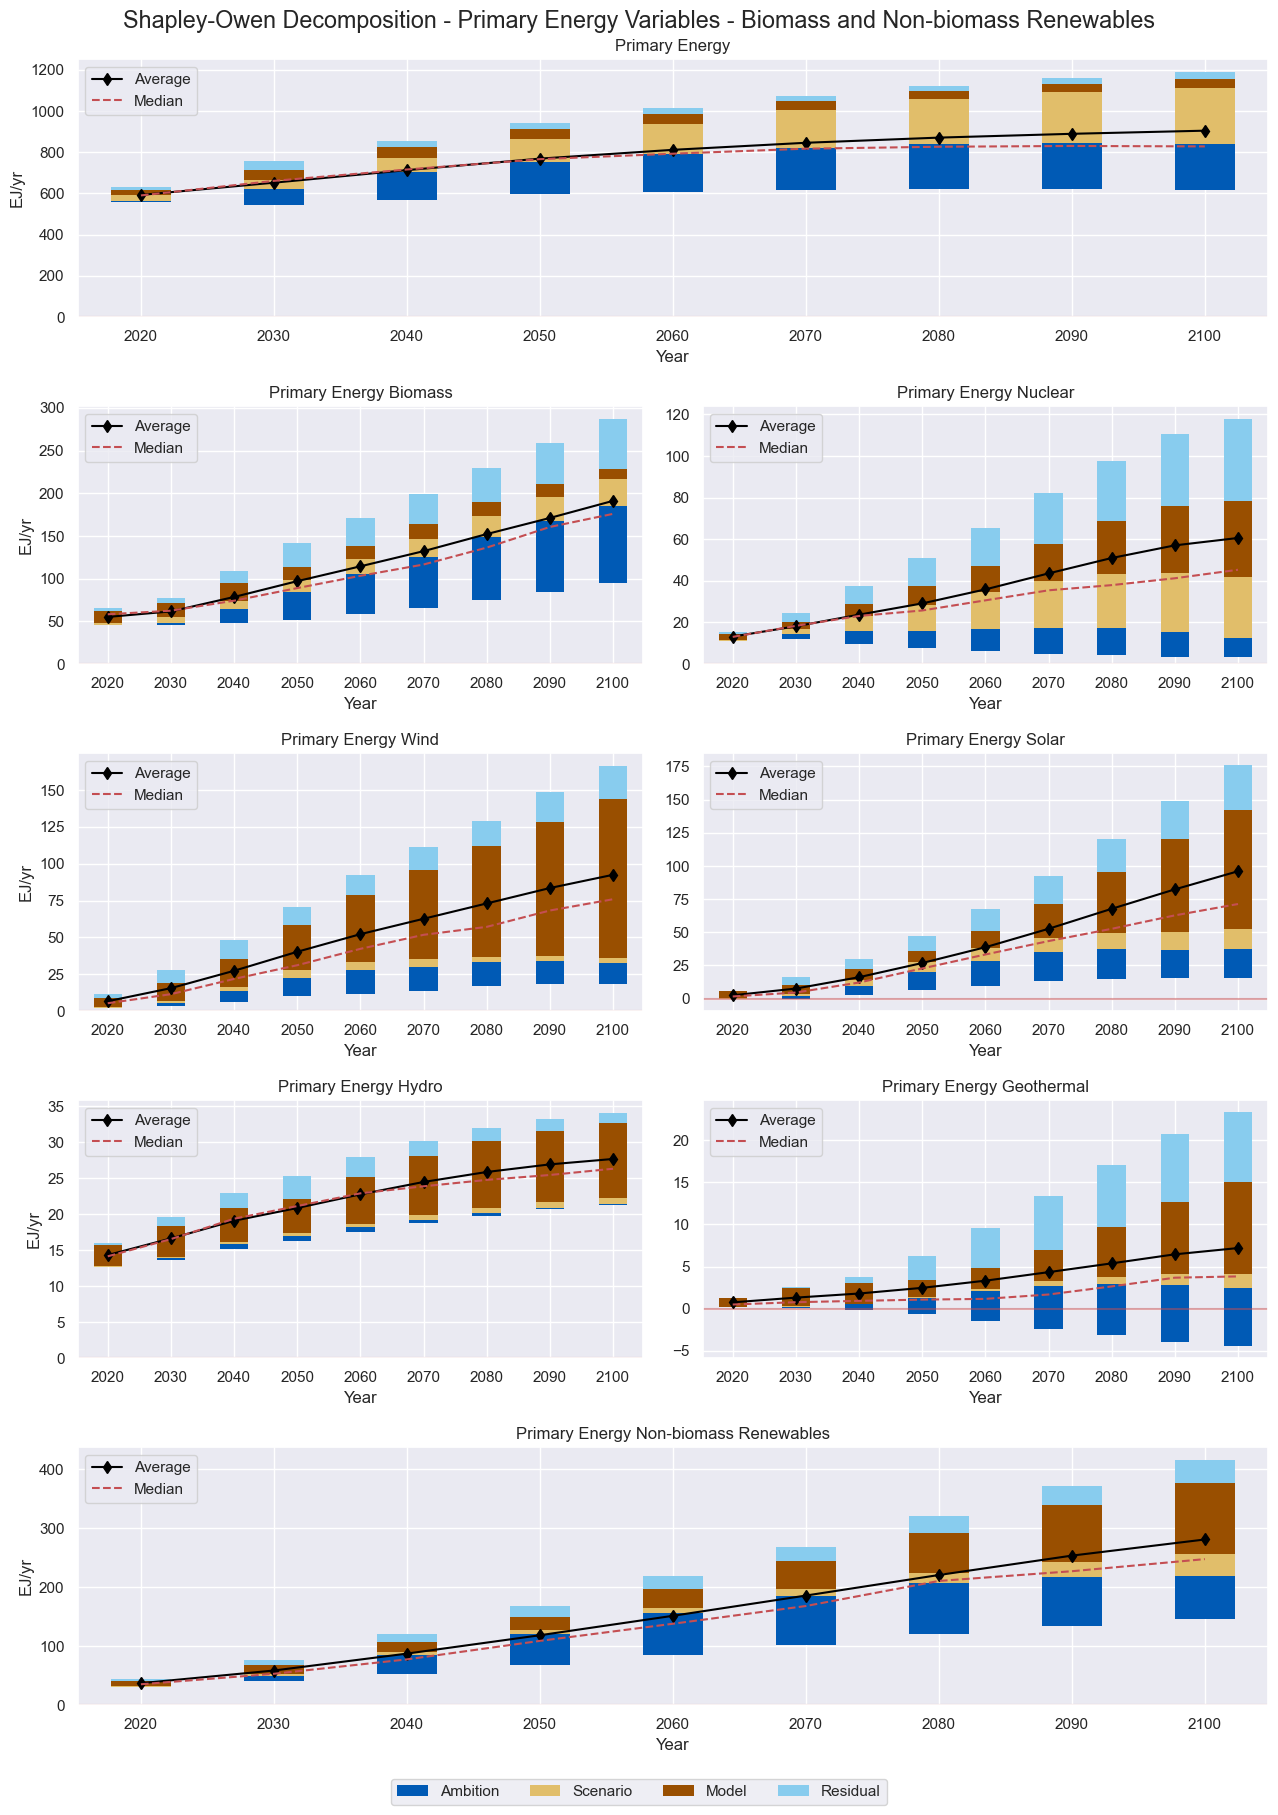

In [46]:
# --------------------------
### Figure 1
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Primary Energy', 
       'Primary Energy Biomass', 
       'Primary Energy Nuclear', 
       'Primary Energy Wind', 
       'Primary Energy Solar', 
       'Primary Energy Hydro',
       'Primary Energy Geothermal', 
       'Primary Energy Non Fossil',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (13,18)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(5, 2, width_ratios=[1,1], height_ratios=[1,1,1,1,1])
ax0 = fig.add_subplot(gs[0, :]) # PE
ax1 = fig.add_subplot(gs[1, 0]) # PE Biomass
ax3 = fig.add_subplot(gs[1, 1]) # PE Nuclear
ax4 = fig.add_subplot(gs[2, 0]) # PE Wind
ax5 = fig.add_subplot(gs[2, 1]) # PE Solar
ax6 = fig.add_subplot(gs[3, 0]) # PE Hydro
ax7 = fig.add_subplot(gs[3, 1]) # PE Geothermal
ax8 = fig.add_subplot(gs[4, :]) # PE Non Biomass Renewables

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax0, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the first panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax0.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax0, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax0, 
        label=None
        )

ax0.set(            
    ylabel=y_axis
    )


# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Biomass'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Biomass', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        )

ax1.set(            
    ylabel=y_axis,
    )


# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Nuclear'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Nuclear', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3,
        )


# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Wind'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Wind', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

ax4.set(            
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fifth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Solar'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax5, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Solar', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax5.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax5, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax5, 
        )


# ----------------------------------------------------
# Sixth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Hydro'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax6, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Hydro', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax6.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax6, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax6,
        )

ax6.set(           
    ylabel=y_axis
    )

# ----------------------------------------------------
# Seventh Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Geothermal'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax7,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Geothermal',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax7.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax7, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax7, 
        )



# ----------------------------------------------------
# Eighth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Non Biomass Renewables'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax8, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Non-biomass Renewables', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax8.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax8,
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax8, 
        label=None
        )

ax8.set(           
    ylabel=y_axis
    )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Primary Energy Variables - Biomass and Non-biomass Renewables') 
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 1
fig.savefig('Figure_1.png', bbox_inches='tight')

Figure 4: Shapley-Owen Decomposition – Primary Energy variables – Fossil Fuels with and without CCS. 

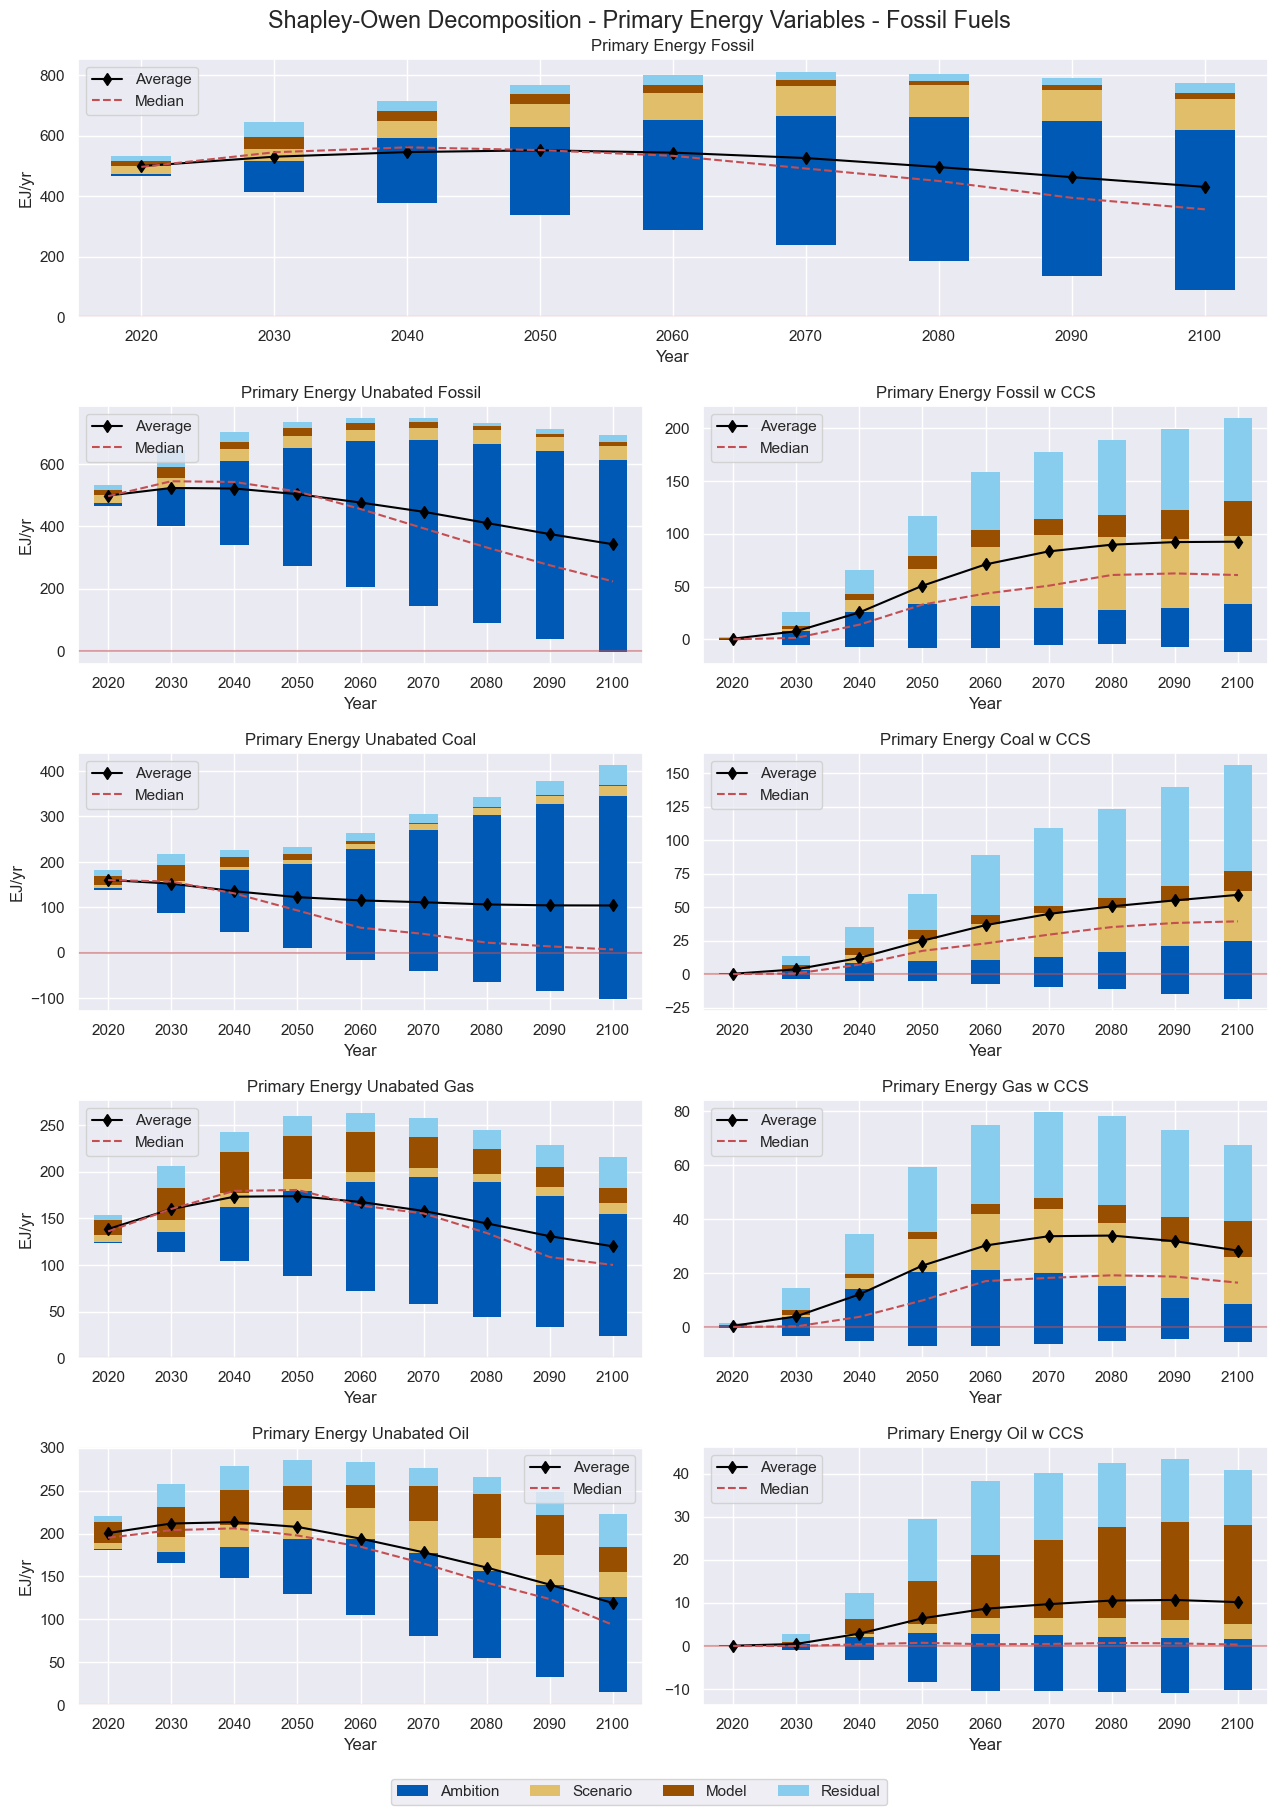

In [47]:
# --------------------------
### Figure 4 
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Primary Energy Fossil',
       'Primary Energy Unabated Fossil',
       'Primary Energy Fossil w CCS', 
       'Primary Energy Unabated Gas',
       'Primary Energy Gas w CCS', 
       'Primary Energy Unabated Coal',
       'Primary Energy Coal w CCS', 
       'Primary Energy Unabated Oil',
       'Primary Energy Oil w CCS',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (13,18)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(5, 2, width_ratios=[1,1], height_ratios=[1,1,1,1,1])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[4, 0])
ax9 = fig.add_subplot(gs[4, 1])

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Fossil'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Fossil', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1,
        label=None
        )

ax1.set( 
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Fossil'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Fossil', 
    legend=None,

    )


# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        label=None
        )

ax2.set(         
    ylabel=y_axis
    )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Fossil w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Fossil w CCS',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3,
        )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Coal'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Coal',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4,
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        label=None
        )

ax4.set(         
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fifth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Coal w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax5, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Coal w CCS', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax5.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax5, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax5,
        )

# ----------------------------------------------------
# Sixth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Gas'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax6,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Gas', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax6.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax6, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax6,
        label=None
        )

ax6.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Seventh Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Gas w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax7,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Gas w CCS', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax7.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax7, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax7, 
        )


# ----------------------------------------------------
# Eighth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Oil'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax8, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Oil', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax8.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax8, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax8, 
        label=None
        )

ax8.set(           
    ylabel=y_axis
    )

# ----------------------------------------------------
# Ninth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Oil w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax9, # to do: select the ax
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Oil w CCS',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax9.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax9, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax9, 
        )
# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Primary Energy Variables - Fossil Fuels') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 4
fig.savefig('Figure_4.png', bbox_inches='tight')

Figure 6: Shapley-Owen Decomposition – CCS and BECCS

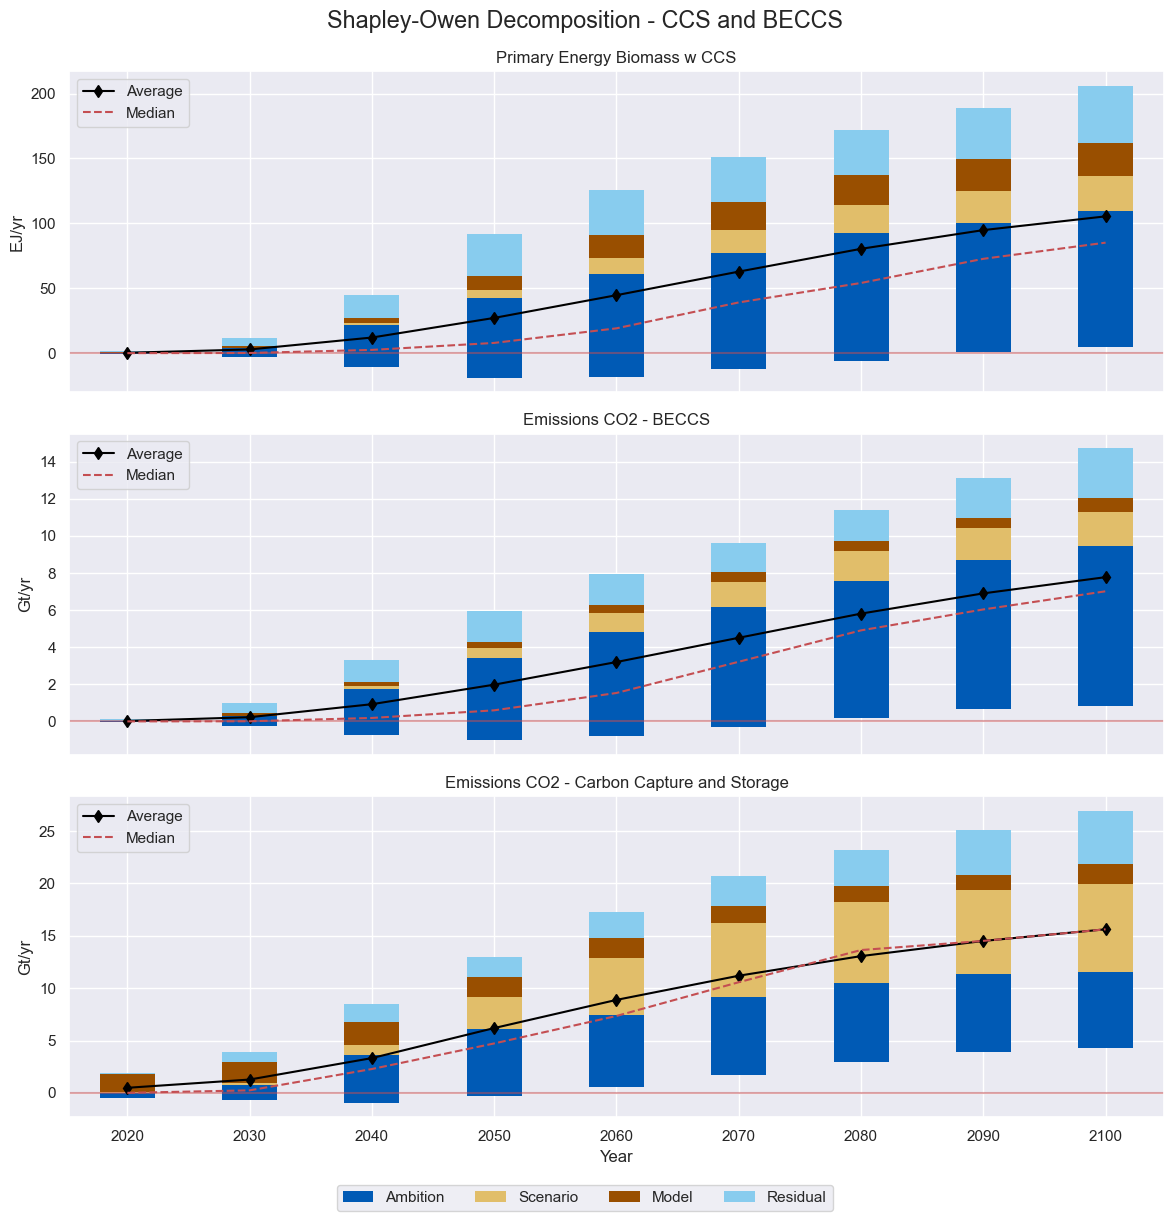

In [48]:
 # --------------------------
### Figure 6
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Primary Energy Biomass w CCS',
       'Emissions CO2 Carbon Capture and Storage Biomass', 
       'Emissions CO2 Carbon Capture and Storage',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,12)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(3, 1, width_ratios=[1], height_ratios=[1,1,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Biomass w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Biomass w CCS', 
    legend=None,

    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set(            
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CO2 Carbon Capture and Storage Biomass'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions CO2 - BECCS', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

ax2.set( 
    ylabel=y_axis,
    )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CO2 Carbon Capture and Storage'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions CO2 - Carbon Capture and Storage', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        )

ax3.set(
    ylabel=y_axis,
   )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - CCS and BECCS') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 6
fig.savefig('Figure_6.png', bbox_inches='tight')


Figure 7: Shapley-Owen Decomposition - Final Energy

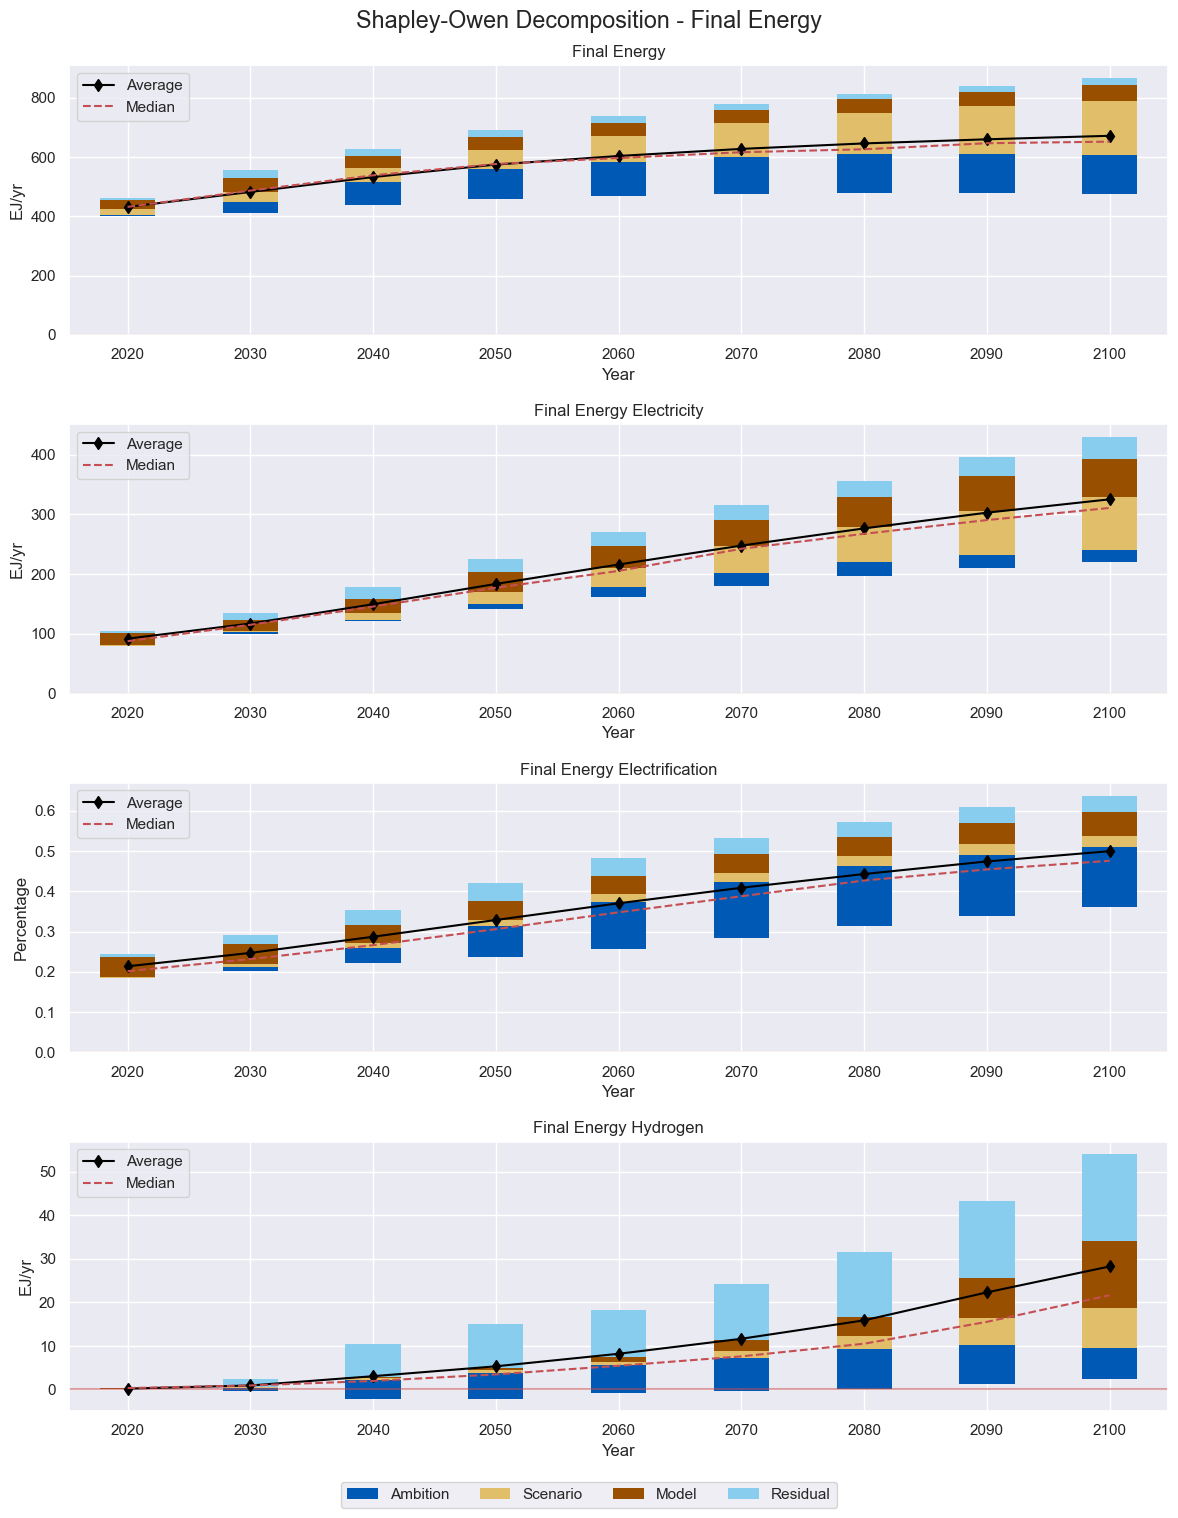

In [49]:
# --------------------------
### Figure 7
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Final Energy', 
       'Final Energy Electricity',
       'Final Energy Electrification',
       'Final Energy Hydrogen', 
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,15)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(4, 1,
                       height_ratios=[1,1,1,1])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[3, :])

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set(       
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Electricity'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Electricity', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2,
        )

ax2.set(
    ylabel=y_axis,
    )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Electrification'
y_axis = 'Percentage'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Electrification',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        )

ax3.set(
    ylabel=y_axis,
    )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Hydrogen'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Hydrogen',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

ax4.set( 
    ylabel=y_axis
    )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Final Energy') 
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 7
fig.savefig('Figure_7.png', bbox_inches='tight')

Figure 8: Shapley-Owen Decomposition – Sectoral Final Energy

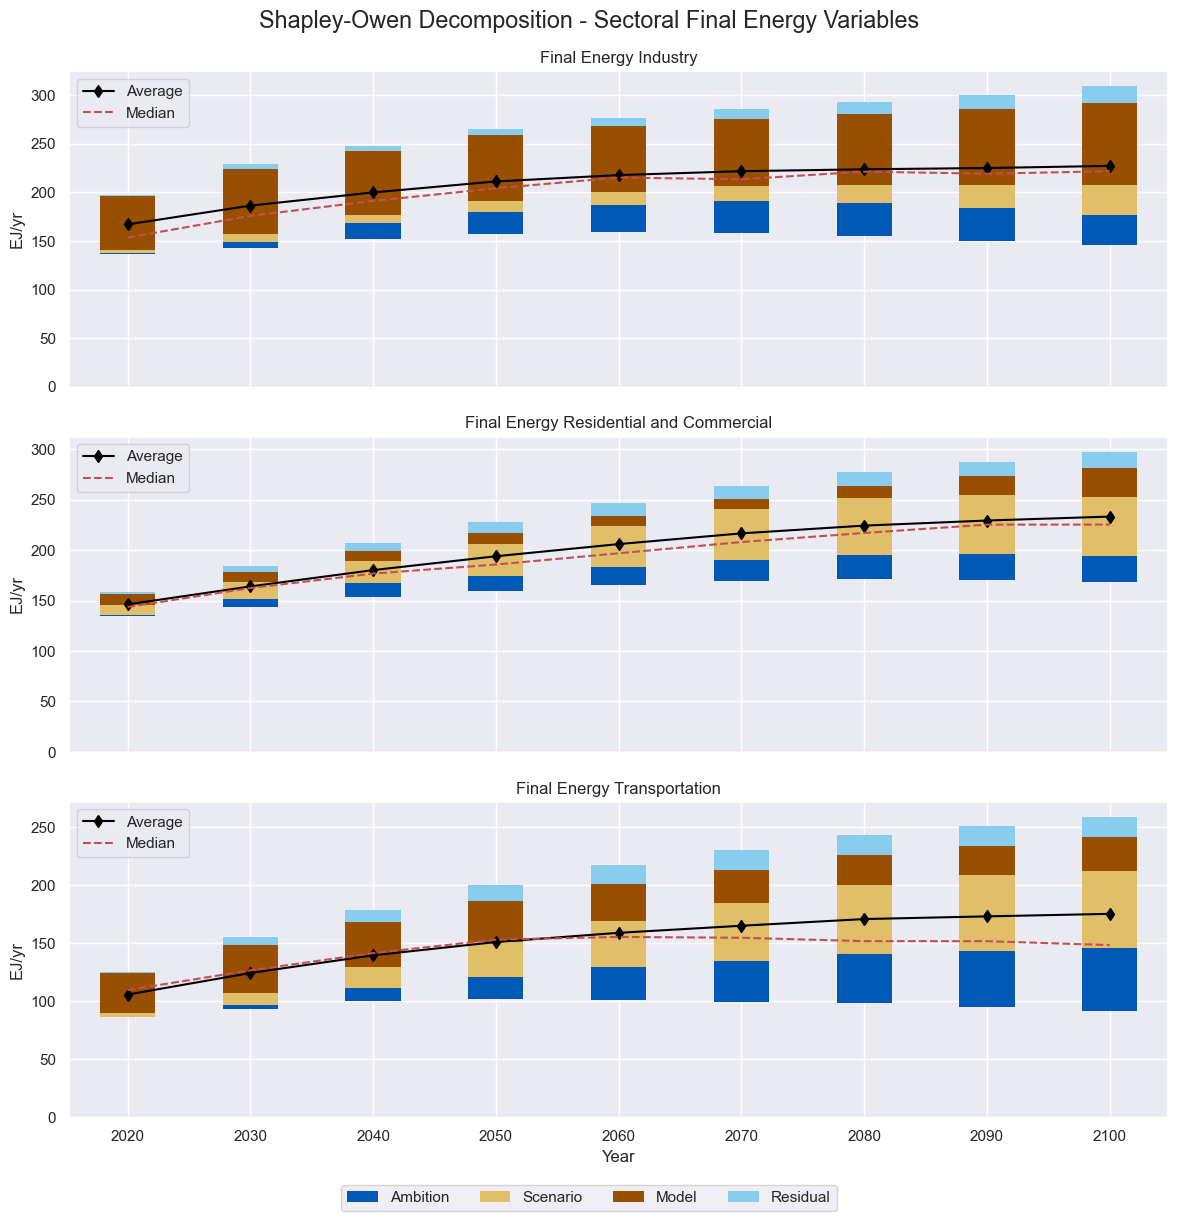

In [50]:
# --------------------------
### Figure 8
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Final Energy Industry',
       'Final Energy Residential and Commercial',
       'Final Energy Transportation',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,12)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(3, 1, width_ratios=[1], height_ratios=[1,1,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Industry'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Industry',
    legend=None,

    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1,
        label=None
        )

ax1.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Residential and Commercial'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Residential and Commercial', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

ax2.set( 
    ylabel=y_axis,

    )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Transportation'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Transportation',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3,
        )

ax3.set(
    ylabel=y_axis
    )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Sectoral Final Energy Variables') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 8
fig.savefig('Figure_8.png', bbox_inches='tight')

Figure 10: Shapley-Owen Decomposition – Energy sector emissions

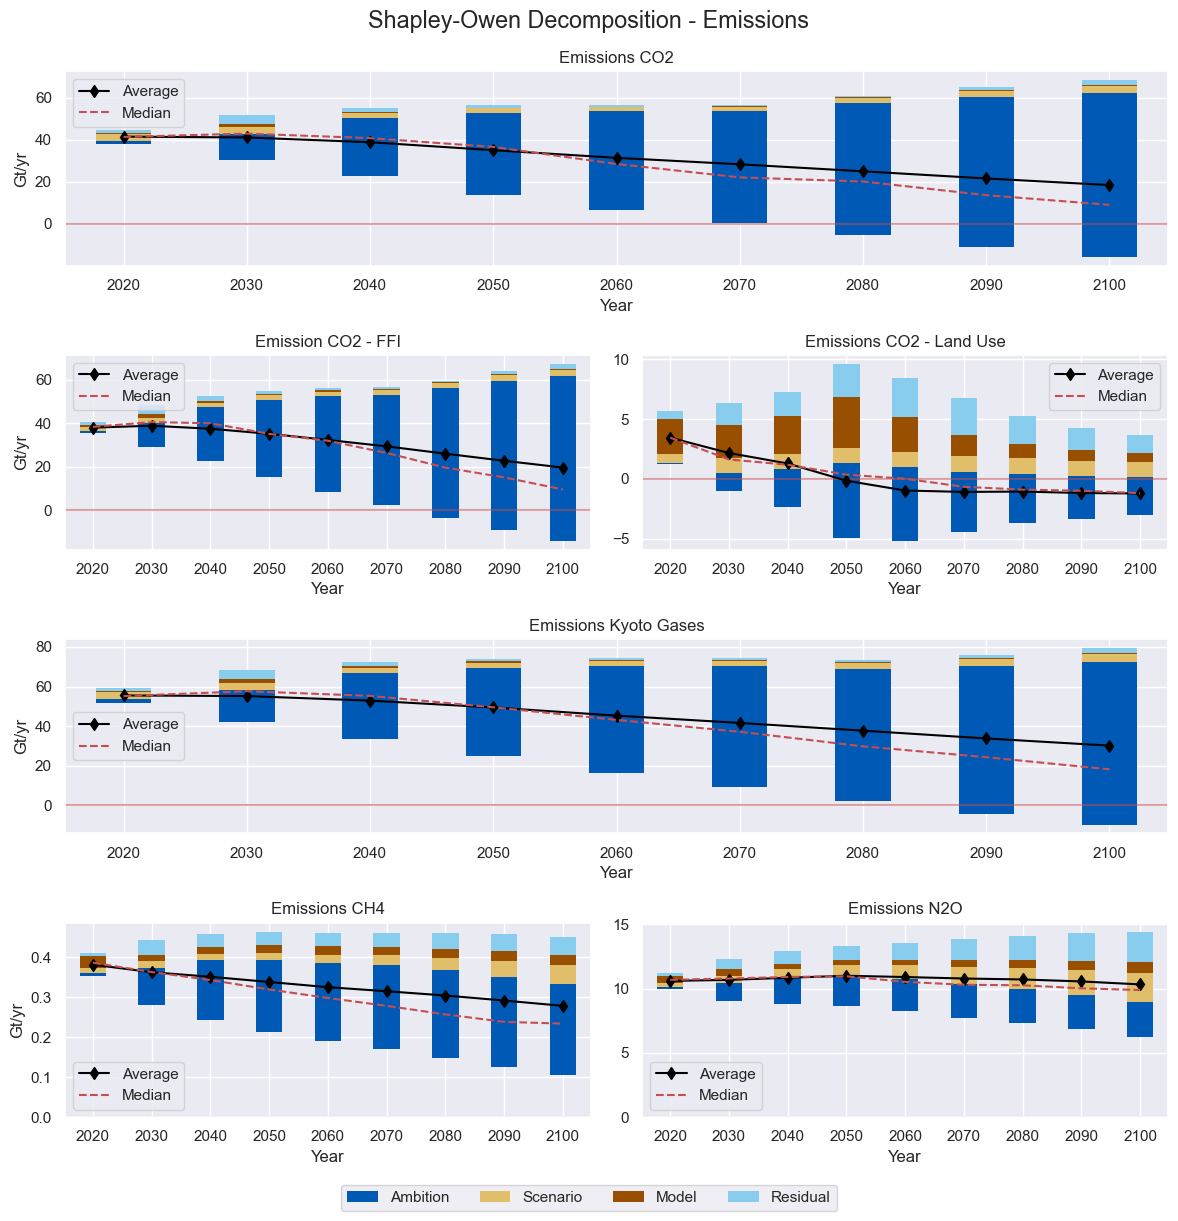

In [51]:
# --------------------------
### Figure 10
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Emissions CO2',
       'Emissions CO2 Fossil Fuels and Industry', 
       'Emissions CO2 Land Use',
       'Emissions Kyoto Gases',
       'Emissions CH4',
       'Emissions N2O', 
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(4, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1])
ax1 = fig.add_subplot(gs[0, :])  # CO2, spans top row
ax2 = fig.add_subplot(gs[1, 0])  # CO2 FFI
ax3 = fig.add_subplot(gs[1, 1])  # CO2 LU
ax4 = fig.add_subplot(gs[2, :])  # KP, spans third row
ax5 = fig.add_subplot(gs[3, 0])  # CH4
ax6 = fig.add_subplot(gs[3, 1])  # N2O

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CO2'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions CO2', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CO2 Fossil Fuels and Industry'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emission CO2 - FFI', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

ax2.set(
    ylabel=y_axis,
    )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CO2 Land Use'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions CO2 - Land Use',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3,
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3,
        )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions Kyoto Gases'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions Kyoto Gases',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

ax4.set( 
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fifth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions CH4'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax5,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions CH4',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax5.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax5, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax5, 
        )

ax5.set(        
    ylabel=y_axis
    )

# ----------------------------------------------------
# Sixth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Emissions N2O'
y_axis = 'Gt/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax6,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Emissions N2O',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax6.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax6, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax6, 
        )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Emissions')
fig.tight_layout()
plt.show()

warnings.filterwarnings('ignore')

# Save the plot as Figure 10
fig.savefig('Figure_10.png', bbox_inches='tight')


Figure 12: Shapley-Owen Decomposition – Economic Variables

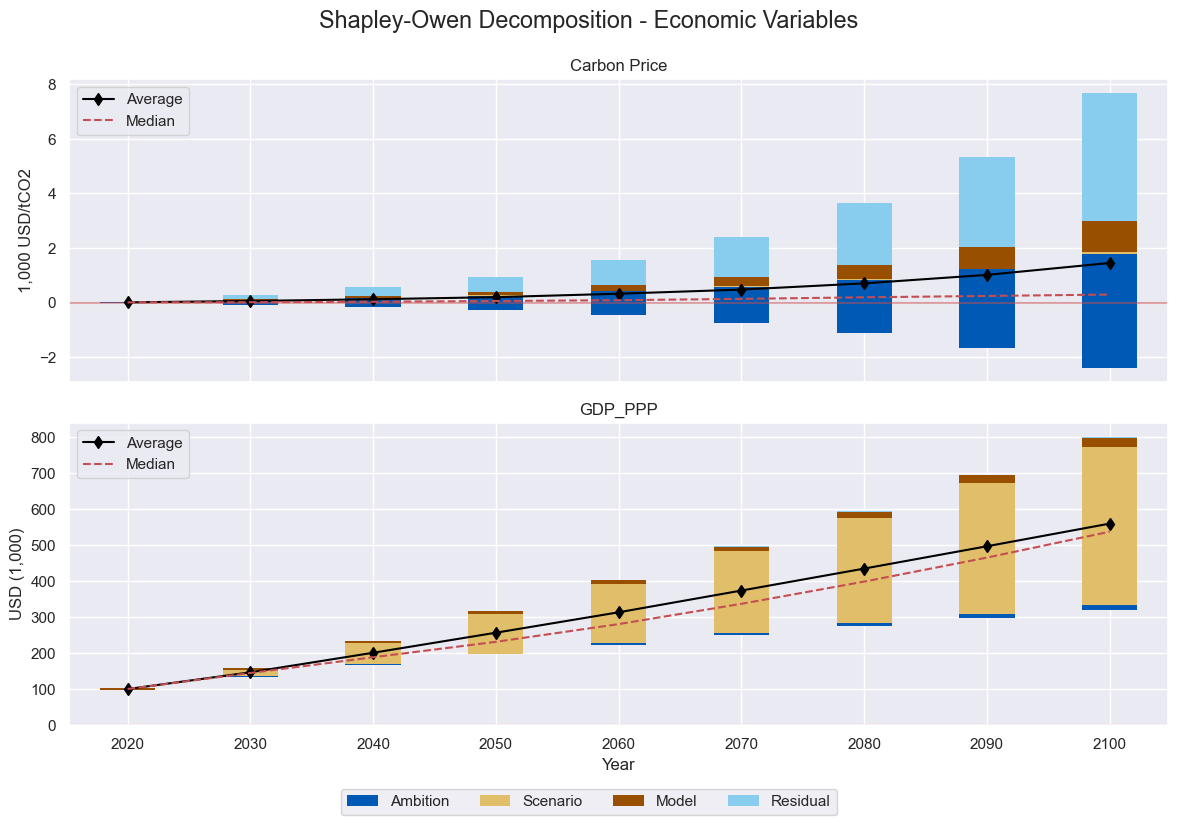

In [52]:
# --------------------------
### Figure 12
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
        'Price Carbon',
       'GDP PPP',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,8)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(2, 1, width_ratios=[1], height_ratios=[1,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Price Carbon'
y_axis = '1,000 USD/tCO2'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Carbon Price', 
    legend=None,

    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set(          
    ylabel=y_axis
    )

# ----------------------------------------------------
# The three plots (stacked and line plots) for var 1
# ----------------------------------------------------

# Inputs to the code
variable = 'GDP PPP'
y_axis = 'USD (1,000)'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    color=colours,
        stacked=True, 
    edgecolor = "none",
    width=0.45,
    title='GDP_PPP',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

ax2.set(            
    ylabel=y_axis,
    )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Economic Variables') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 12
fig.savefig('Figure_12.png', bbox_inches='tight')


Figure D.1: Shapley-Owen Decomposition - Final Energy for additional carriers

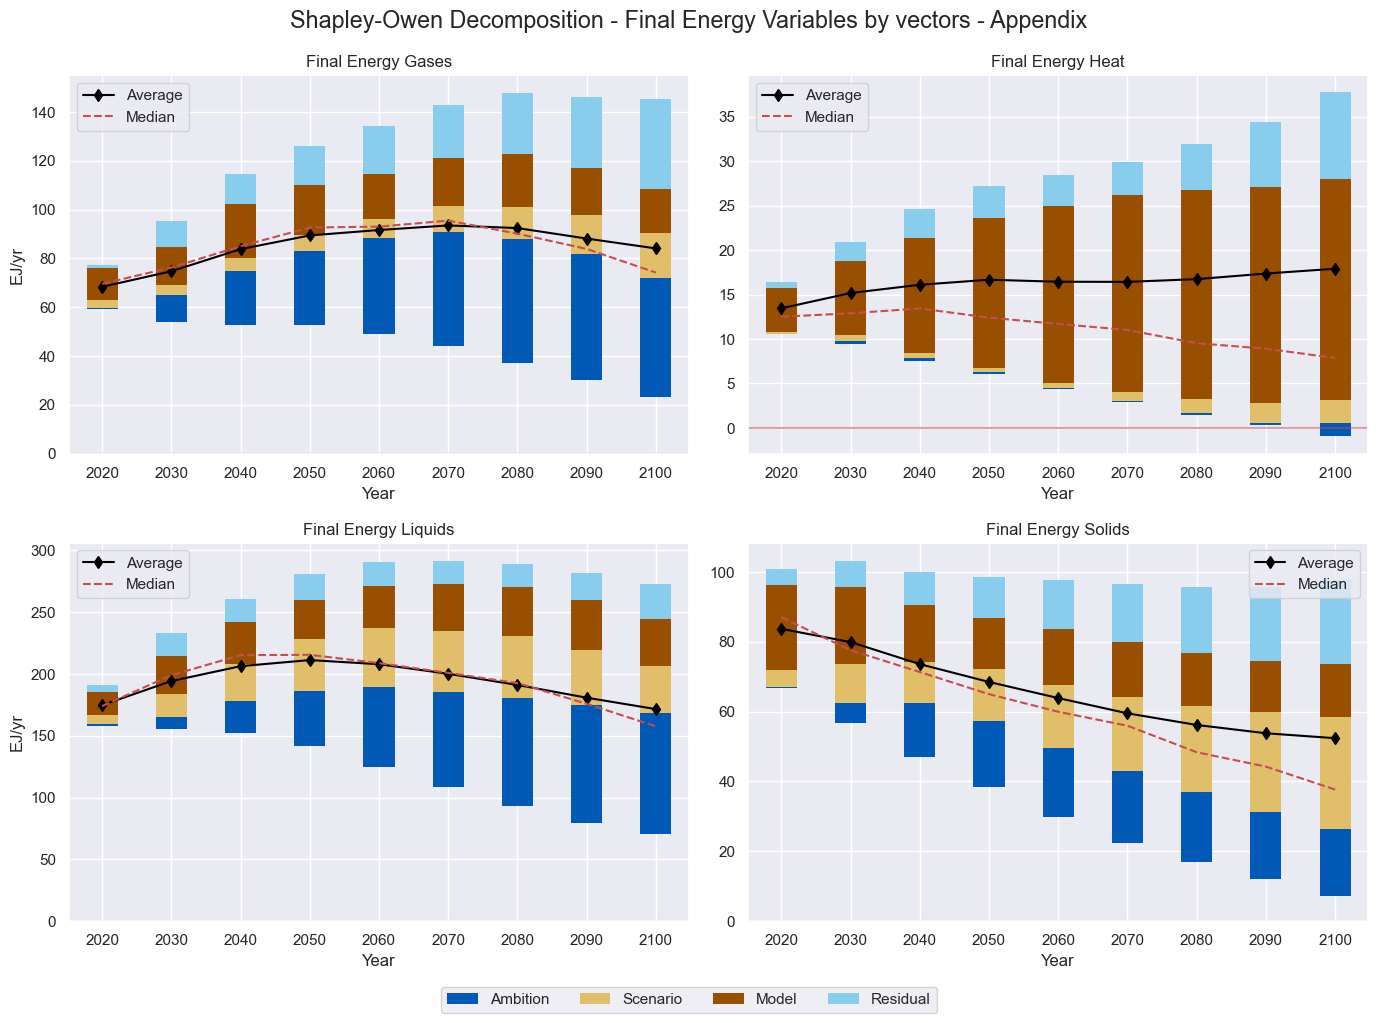

In [53]:
# --------------------------
### Figure D.1
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Final Energy Gases',
       'Final Energy Heat', 
       'Final Energy Liquids', 
       'Final Energy Solids',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (14,10)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Gases'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Gases',
    legend=None,

    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# sECOND Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Heat'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Heat',
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Liquids'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Liquids', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        )

ax3.set( 
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Solids'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Solids', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Final Energy Variables by vectors - Appendix') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure D.1
fig.savefig('Figure_D1.png', bbox_inches='tight')

Appendix E: Comparative diagnostics of climate ambition representation in Shapley-Owen decomposition: quadratic emissions function versus RCP dummy variables

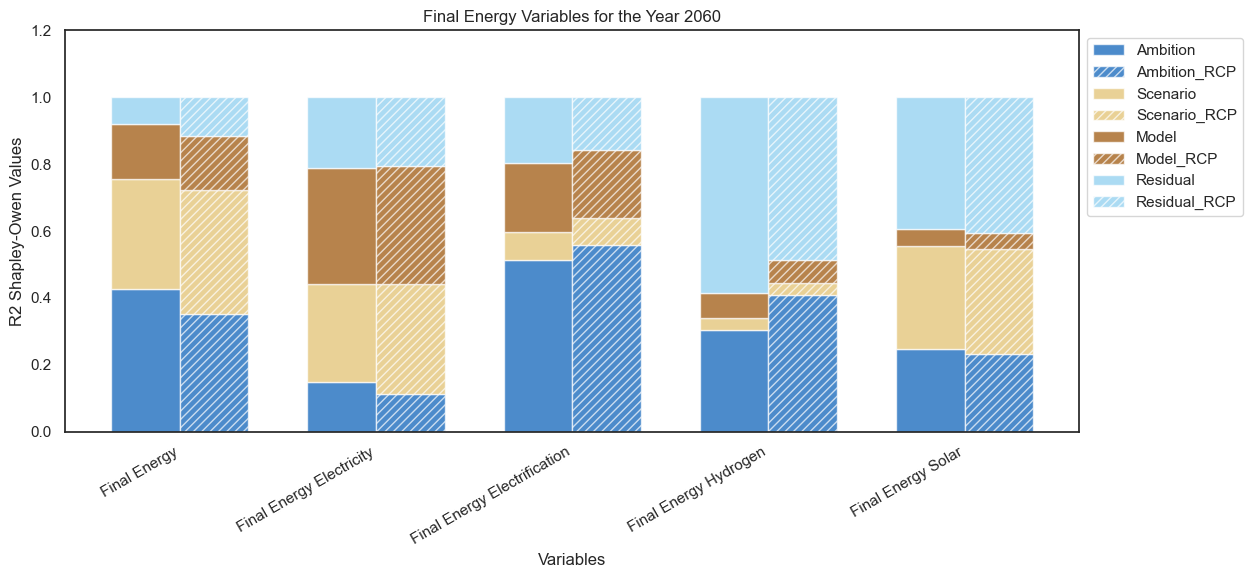

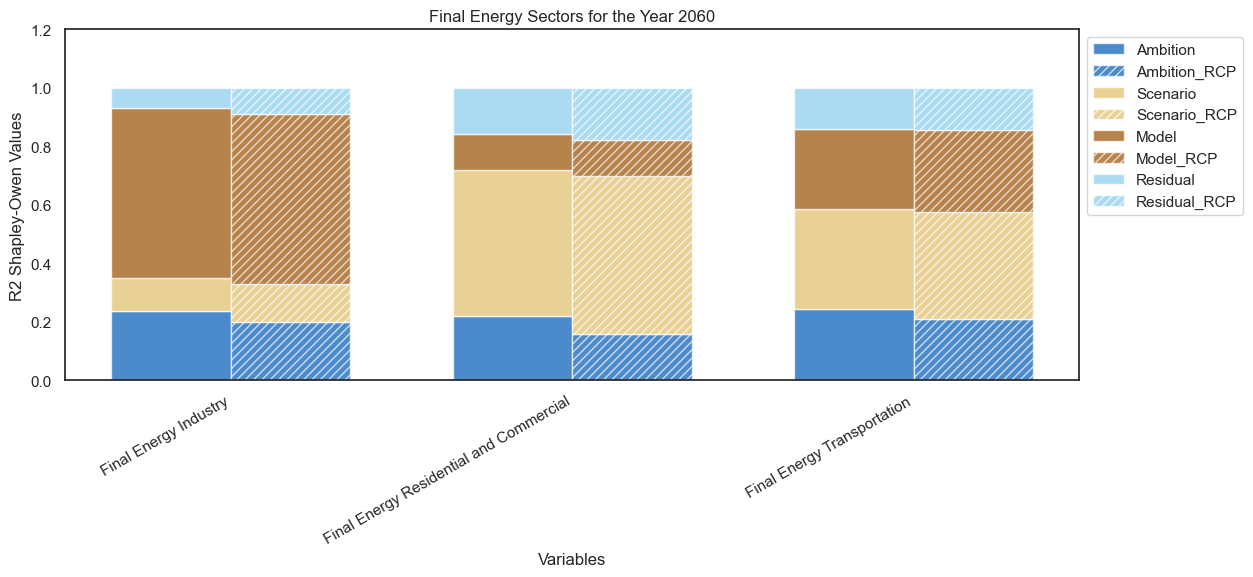

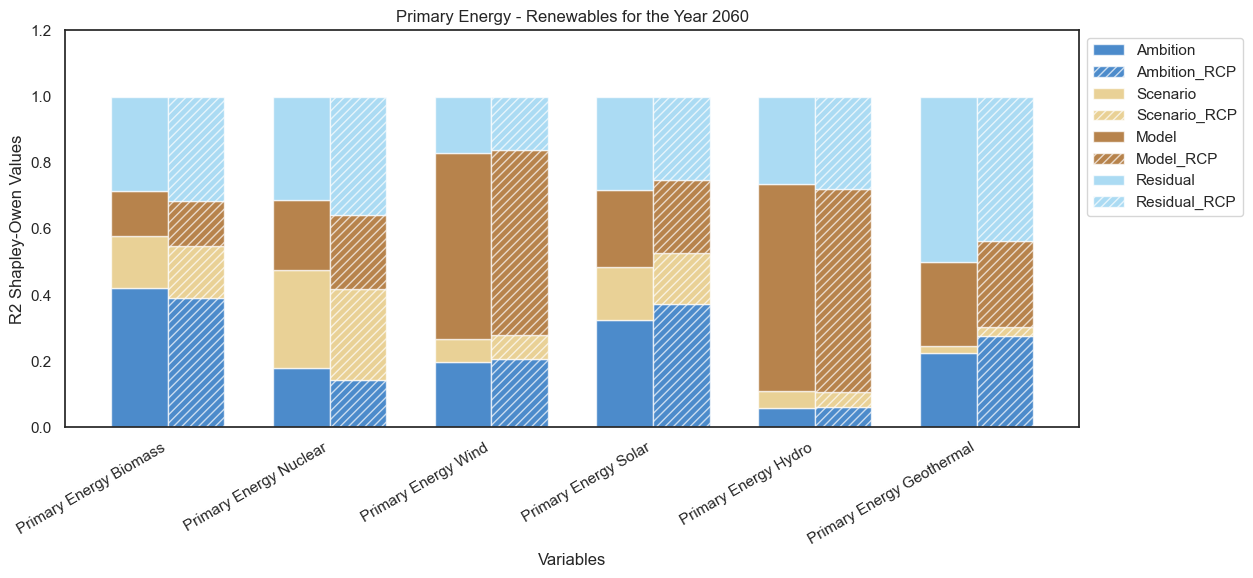

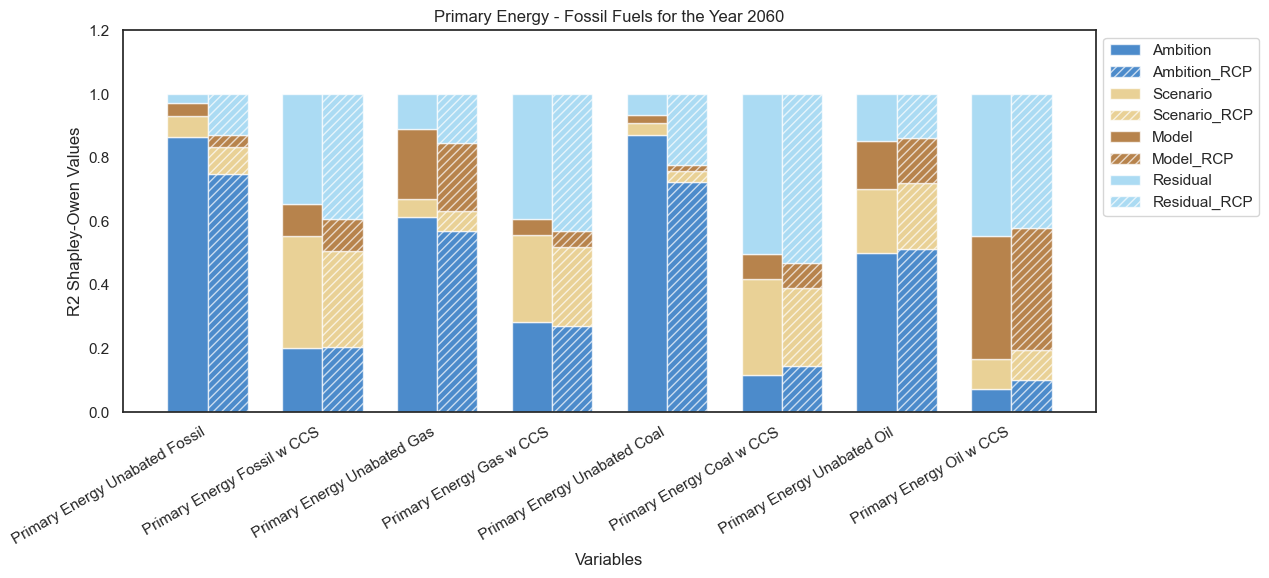

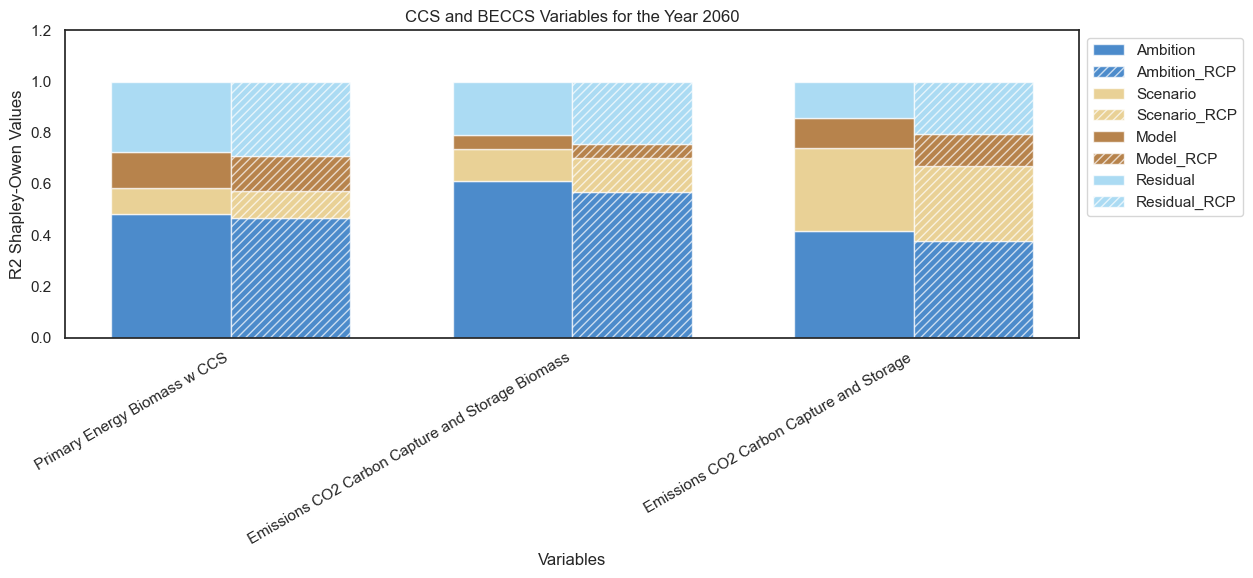

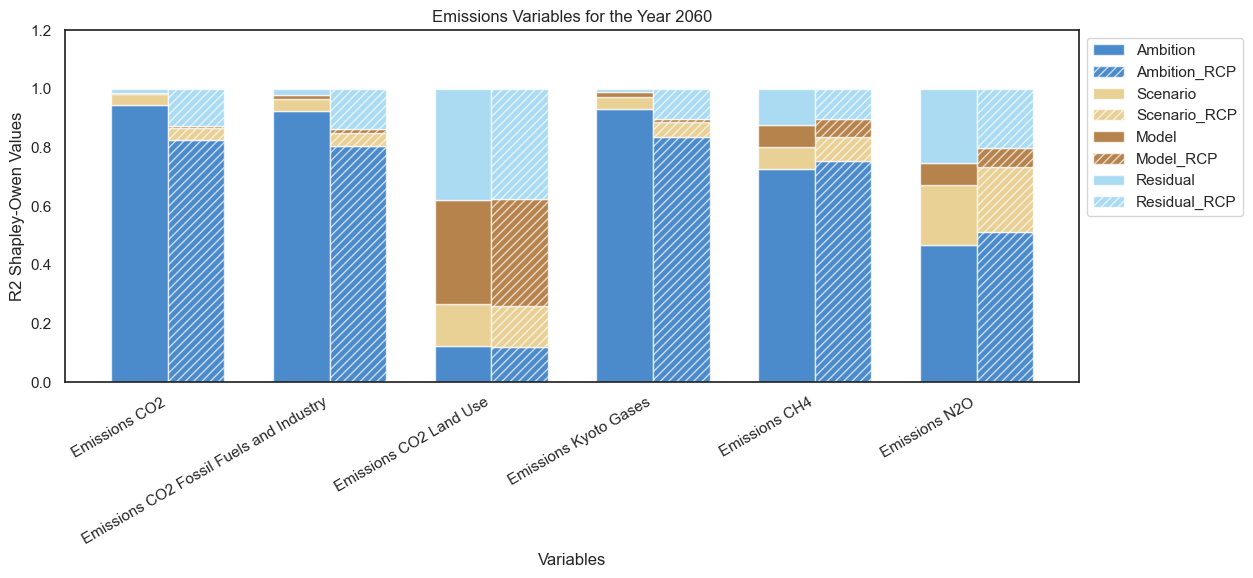

In [54]:
# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("white")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (12,6)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

df = df_all
df_2060 = df[df['Year'] == 2060]

# Columns and custom colours
original_cols = ['R2_Amb_Shapley', 'R2_Scen_Shapley', 'R2_Mod_Shapley', 'R2_Residual']
rcp_cols = [col + '_rcp' for col in original_cols]
custom_colours = {
    'R2_Amb_Shapley': '#005AB5',
    'R2_Scen_Shapley': '#E1BE6A',
    'R2_Mod_Shapley': '#994F00',
    'R2_Residual': '#88CCEE'
}
rcp_hatch = '//' * 2  

# Variable groups (abbreviated for brevity)
variable_groups = {
    'Final Energy Variables': ['Final Energy', 'Final Energy Electricity', 'Final Energy Electrification', 'Final Energy Hydrogen', 'Final Energy Solar'],
   # 'Final Energy Vectors': ['Final Energy Gases', 'Final Energy Heat', 'Final Energy Liquids', 'Final Energy Solids'],
    'Final Energy Sectors': ['Final Energy Industry', 'Final Energy Residential and Commercial', 'Final Energy Transportation'],
    'Primary Energy - Renewables': [ 'Primary Energy Biomass', 'Primary Energy Nuclear', 'Primary Energy Wind', 'Primary Energy Solar', 'Primary Energy Hydro', 'Primary Energy Geothermal'],
    'Primary Energy - Fossil Fuels': ['Primary Energy Unabated Fossil', 'Primary Energy Fossil w CCS', 'Primary Energy Unabated Gas', 'Primary Energy Gas w CCS', 'Primary Energy Unabated Coal', 'Primary Energy Coal w CCS', 'Primary Energy Unabated Oil', 'Primary Energy Oil w CCS'],
    'CCS and BECCS Variables': ['Primary Energy Biomass w CCS', 'Emissions CO2 Carbon Capture and Storage Biomass', 'Emissions CO2 Carbon Capture and Storage'],
    'Emissions Variables': ['Emissions CO2', 'Emissions CO2 Fossil Fuels and Industry', 'Emissions CO2 Land Use', 'Emissions Kyoto Gases', 'Emissions CH4', 'Emissions N2O'],
    # 'Economic Variables': ['Price Carbon', 'GDP PPP']
}

# Create plots
for group, variables in variable_groups.items():
    plt.figure(figsize=(15, 6))
    bar_width = 0.35
    index = np.arange(len(variables))
    handles_dict = {}  # To store handles for the legend
    for idx, variable in enumerate(variables):
        original_data = df_2060[df_2060['Variable'] == variable][original_cols].values.flatten()
        rcp_data = df_2060[df_2060['Variable'] == variable][rcp_cols].values.flatten()
        bottom_value_original = 0
        bottom_value_rcp = 0
        for o_val, r_val, o_col, r_col in zip(original_data, rcp_data, original_cols, rcp_cols):
            label_original = o_col.split('_')[1]
            # Rename the Amb with Ambition, Scen with Scenario, Mod with Model, Residual with Residual
            if label_original == 'Amb':
                label_original = 'Ambition'
            elif label_original == 'Scen':
                label_original = 'Scenario'
            elif label_original == 'Mod':
                label_original = 'Model'
            elif label_original == 'Residual':
                label_original = 'Residual'
            label_rcp = f"{label_original}_RCP"
            handle_original = plt.bar(index[idx] - bar_width / 2, o_val, bar_width, 
                                      color=custom_colours[o_col], alpha=0.7, bottom=bottom_value_original)
            handle_rcp = plt.bar(index[idx] + bar_width / 2, r_val, bar_width, 
                                 color=custom_colours[o_col], alpha=0.7, bottom=bottom_value_rcp, hatch=rcp_hatch)
            if label_original not in handles_dict:
                handles_dict[label_original] = handle_original
            if label_rcp not in handles_dict:
                handles_dict[label_rcp] = handle_rcp
            bottom_value_original += o_val
            bottom_value_rcp += r_val

    plt.xlabel('Variables')
    plt.ylabel('R2 Shapley-Owen Values')
    plt.ylim([0, 1.2])
    plt.title(f'{group} for the Year 2060')
    plt.xticks(index, variables, rotation=30, ha='right')
    # Add legend for the handles as follows: Ambition, Scenario, Model, Residual, Ambition_RCP, Scenario_RCP, Model_RCP, Residual_RCP
    plt.legend(handles_dict.values(), handles_dict.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the plots as Figure E.1, through E.6
    plt.savefig(f'Figure_E{list(variable_groups.keys()).index(group) + 1}.png')
    plt.show()

    


Shapley-Owen decomposition figure repeated - slides-friendly 

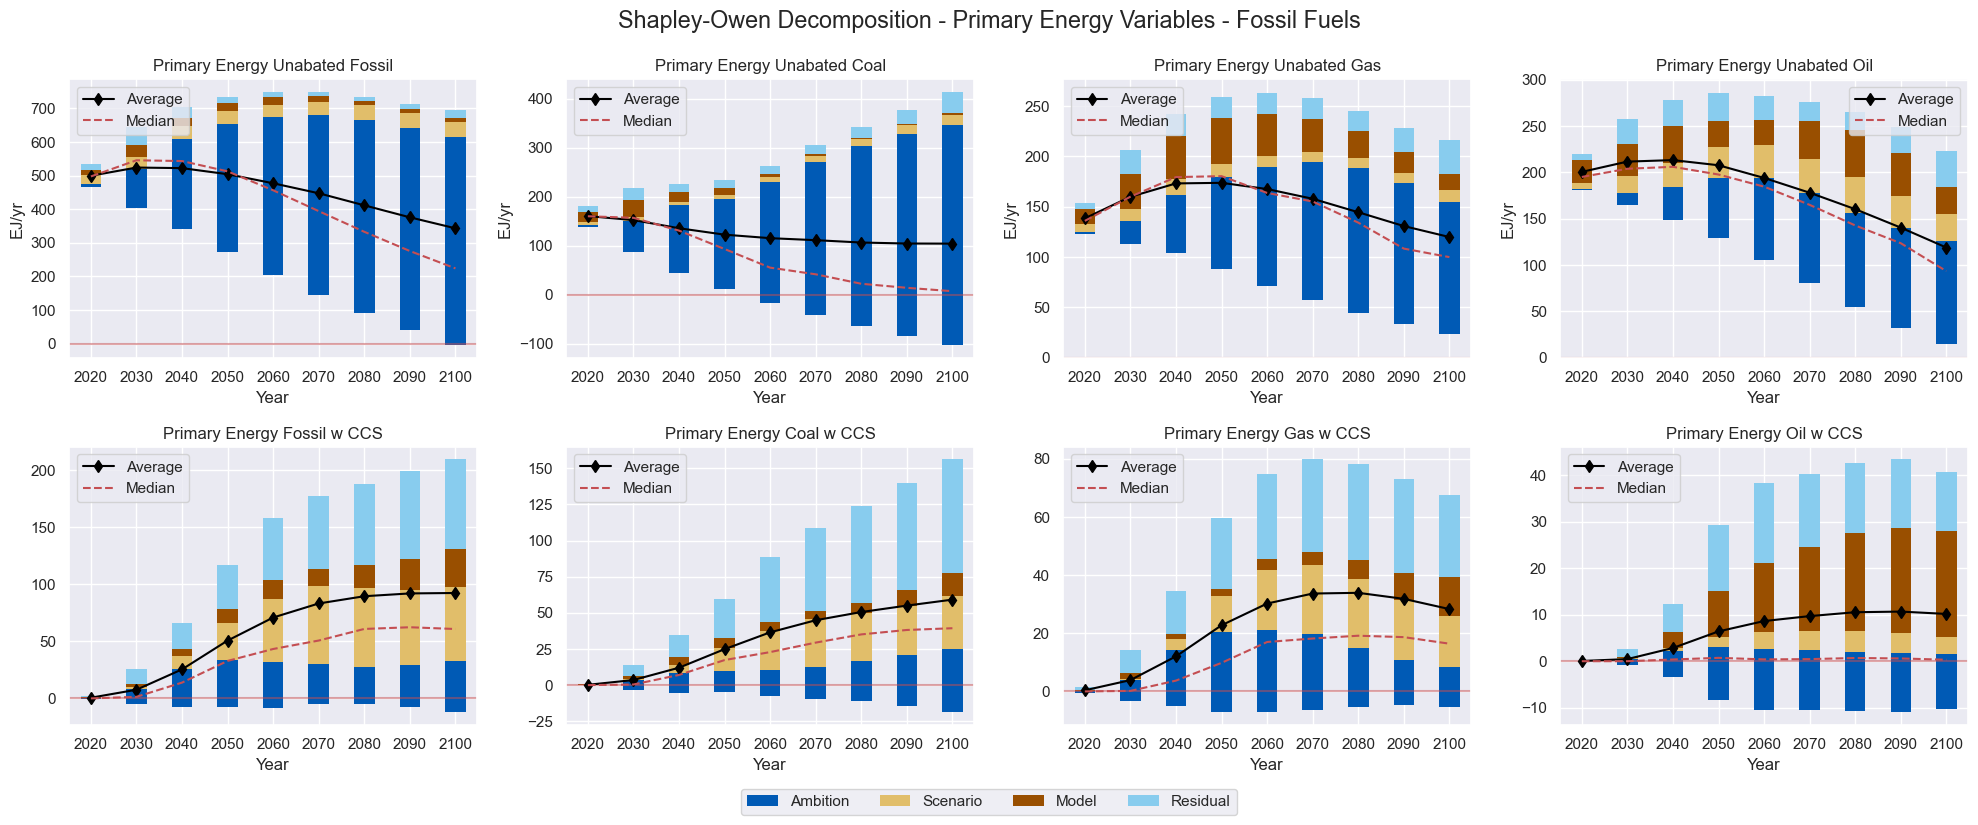

In [55]:
# --------------------------
### Figure 4 - Replica for slides
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Primary Energy Unabated Fossil',
       'Primary Energy Fossil w CCS', 
       'Primary Energy Unabated Gas',
       'Primary Energy Gas w CCS', 
       'Primary Energy Unabated Coal',
       'Primary Energy Coal w CCS', 
       'Primary Energy Unabated Oil',
       'Primary Energy Oil w CCS',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (20,8)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(2, 4, width_ratios=[1,1,1,1], height_ratios=[1,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[0, 3])
ax8 = fig.add_subplot(gs[1, 3])

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Fossil'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Fossil',  
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set( 
    ylabel=y_axis
    )

# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Fossil w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Fossil w CCS', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, # to do: select the ax
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Gas'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Gas',  
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        label=None
        )

ax3.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Gas w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Gas w CCS',
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

# ----------------------------------------------------
# Fifth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Coal'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax5,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Coal', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax5.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax5, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax5, 
        label=None
        )

ax5.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Sixth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Coal w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax6,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Coal w CCS', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax6.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax6, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax6, 
        )

# ----------------------------------------------------
# Seventh Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Unabated Oil'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax7, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Unabated Oil', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax7.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax7, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax7, 
        label=None
        )

ax7.set(
    ylabel=y_axis
    )

# ----------------------------------------------------
# Eighth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Oil w CCS'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax8, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Oil w CCS', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax8.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax8, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax8, 
        )


# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Primary Energy Variables - Fossil Fuels') # to do: change the title
fig.tight_layout()
plt.show() 


warnings.filterwarnings('ignore')

# Save the plot as Figure 4
fig.savefig('Figure_4_slides.png', bbox_inches='tight')

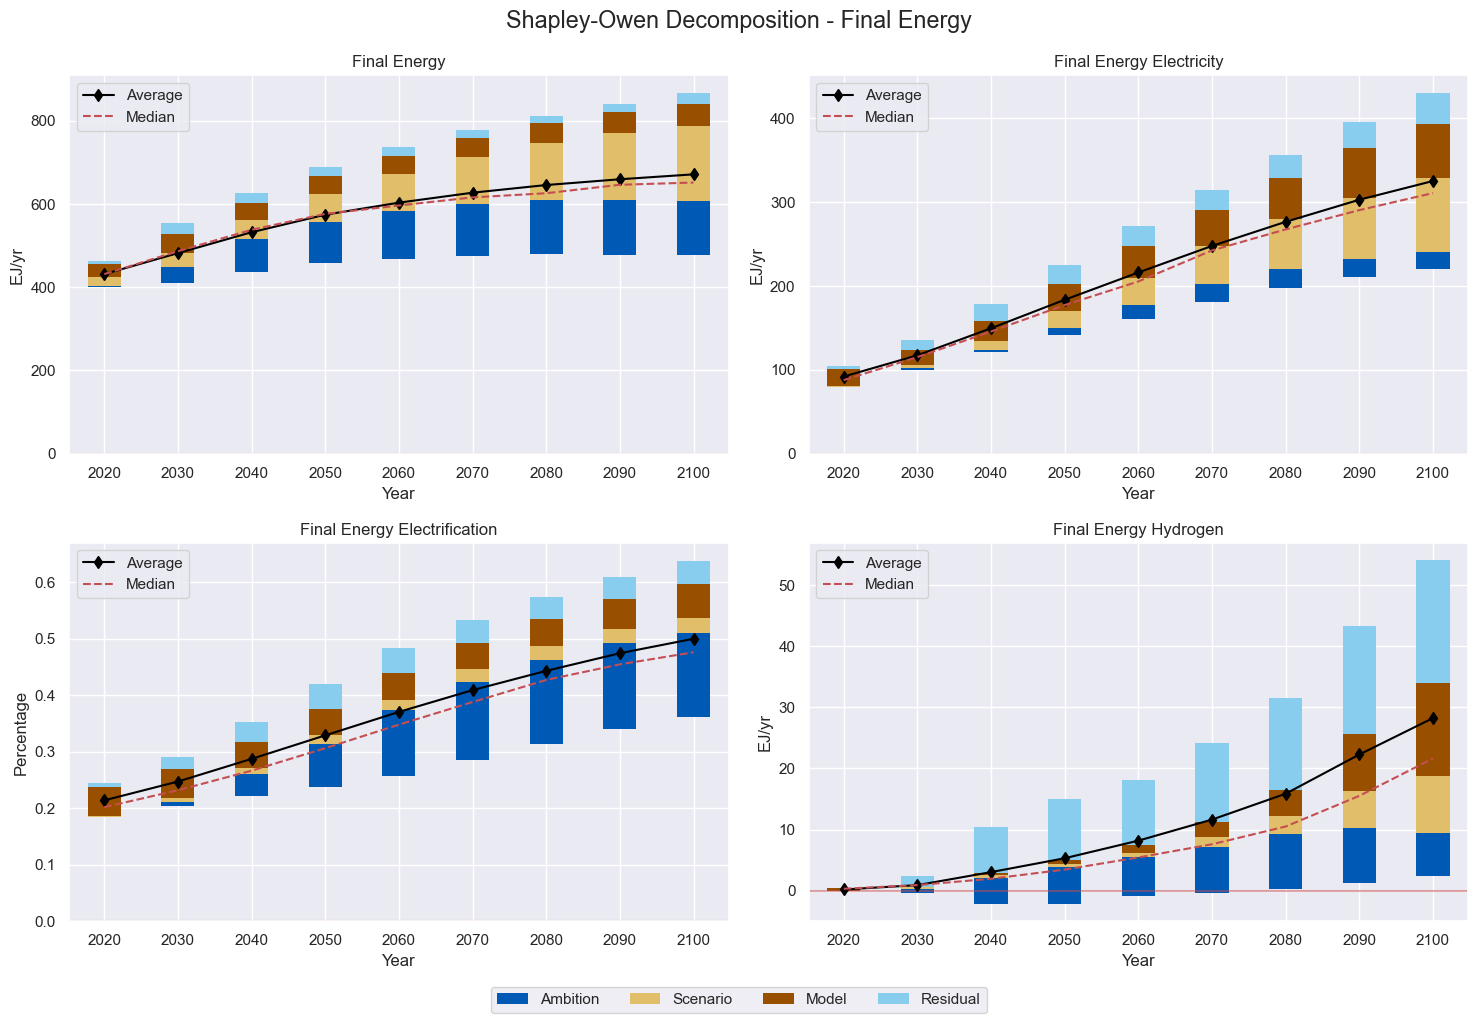

In [56]:
# --------------------------
### Figure 7 - Replica for slides
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Final Energy', 
       'Final Energy Electricity',
       'Final Energy Electrification',
       'Final Energy Hydrogen', 
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (15,10)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure()
gs = fig.add_gridspec(2,2,
                        width_ratios=[1,1], 
                       height_ratios=[1,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        label=None
        )

ax1.set( 
    ylabel=y_axis
    )

# ----------------------------------------------------
# second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Electricity'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax2, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Electricity', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax2.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax2, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax2, 
        )

ax2.set(          
    ylabel=y_axis,
    )


# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Electrification'
y_axis = 'Percentage'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Electrification', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        )

ax3.set(        
    ylabel=y_axis,
    )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Final Energy Hydrogen'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Final Energy Hydrogen', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4,
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

ax4.set(  
    ylabel=y_axis
    )

# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Final Energy') 
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 7
fig.savefig('Figure_7_slides.png', bbox_inches='tight')

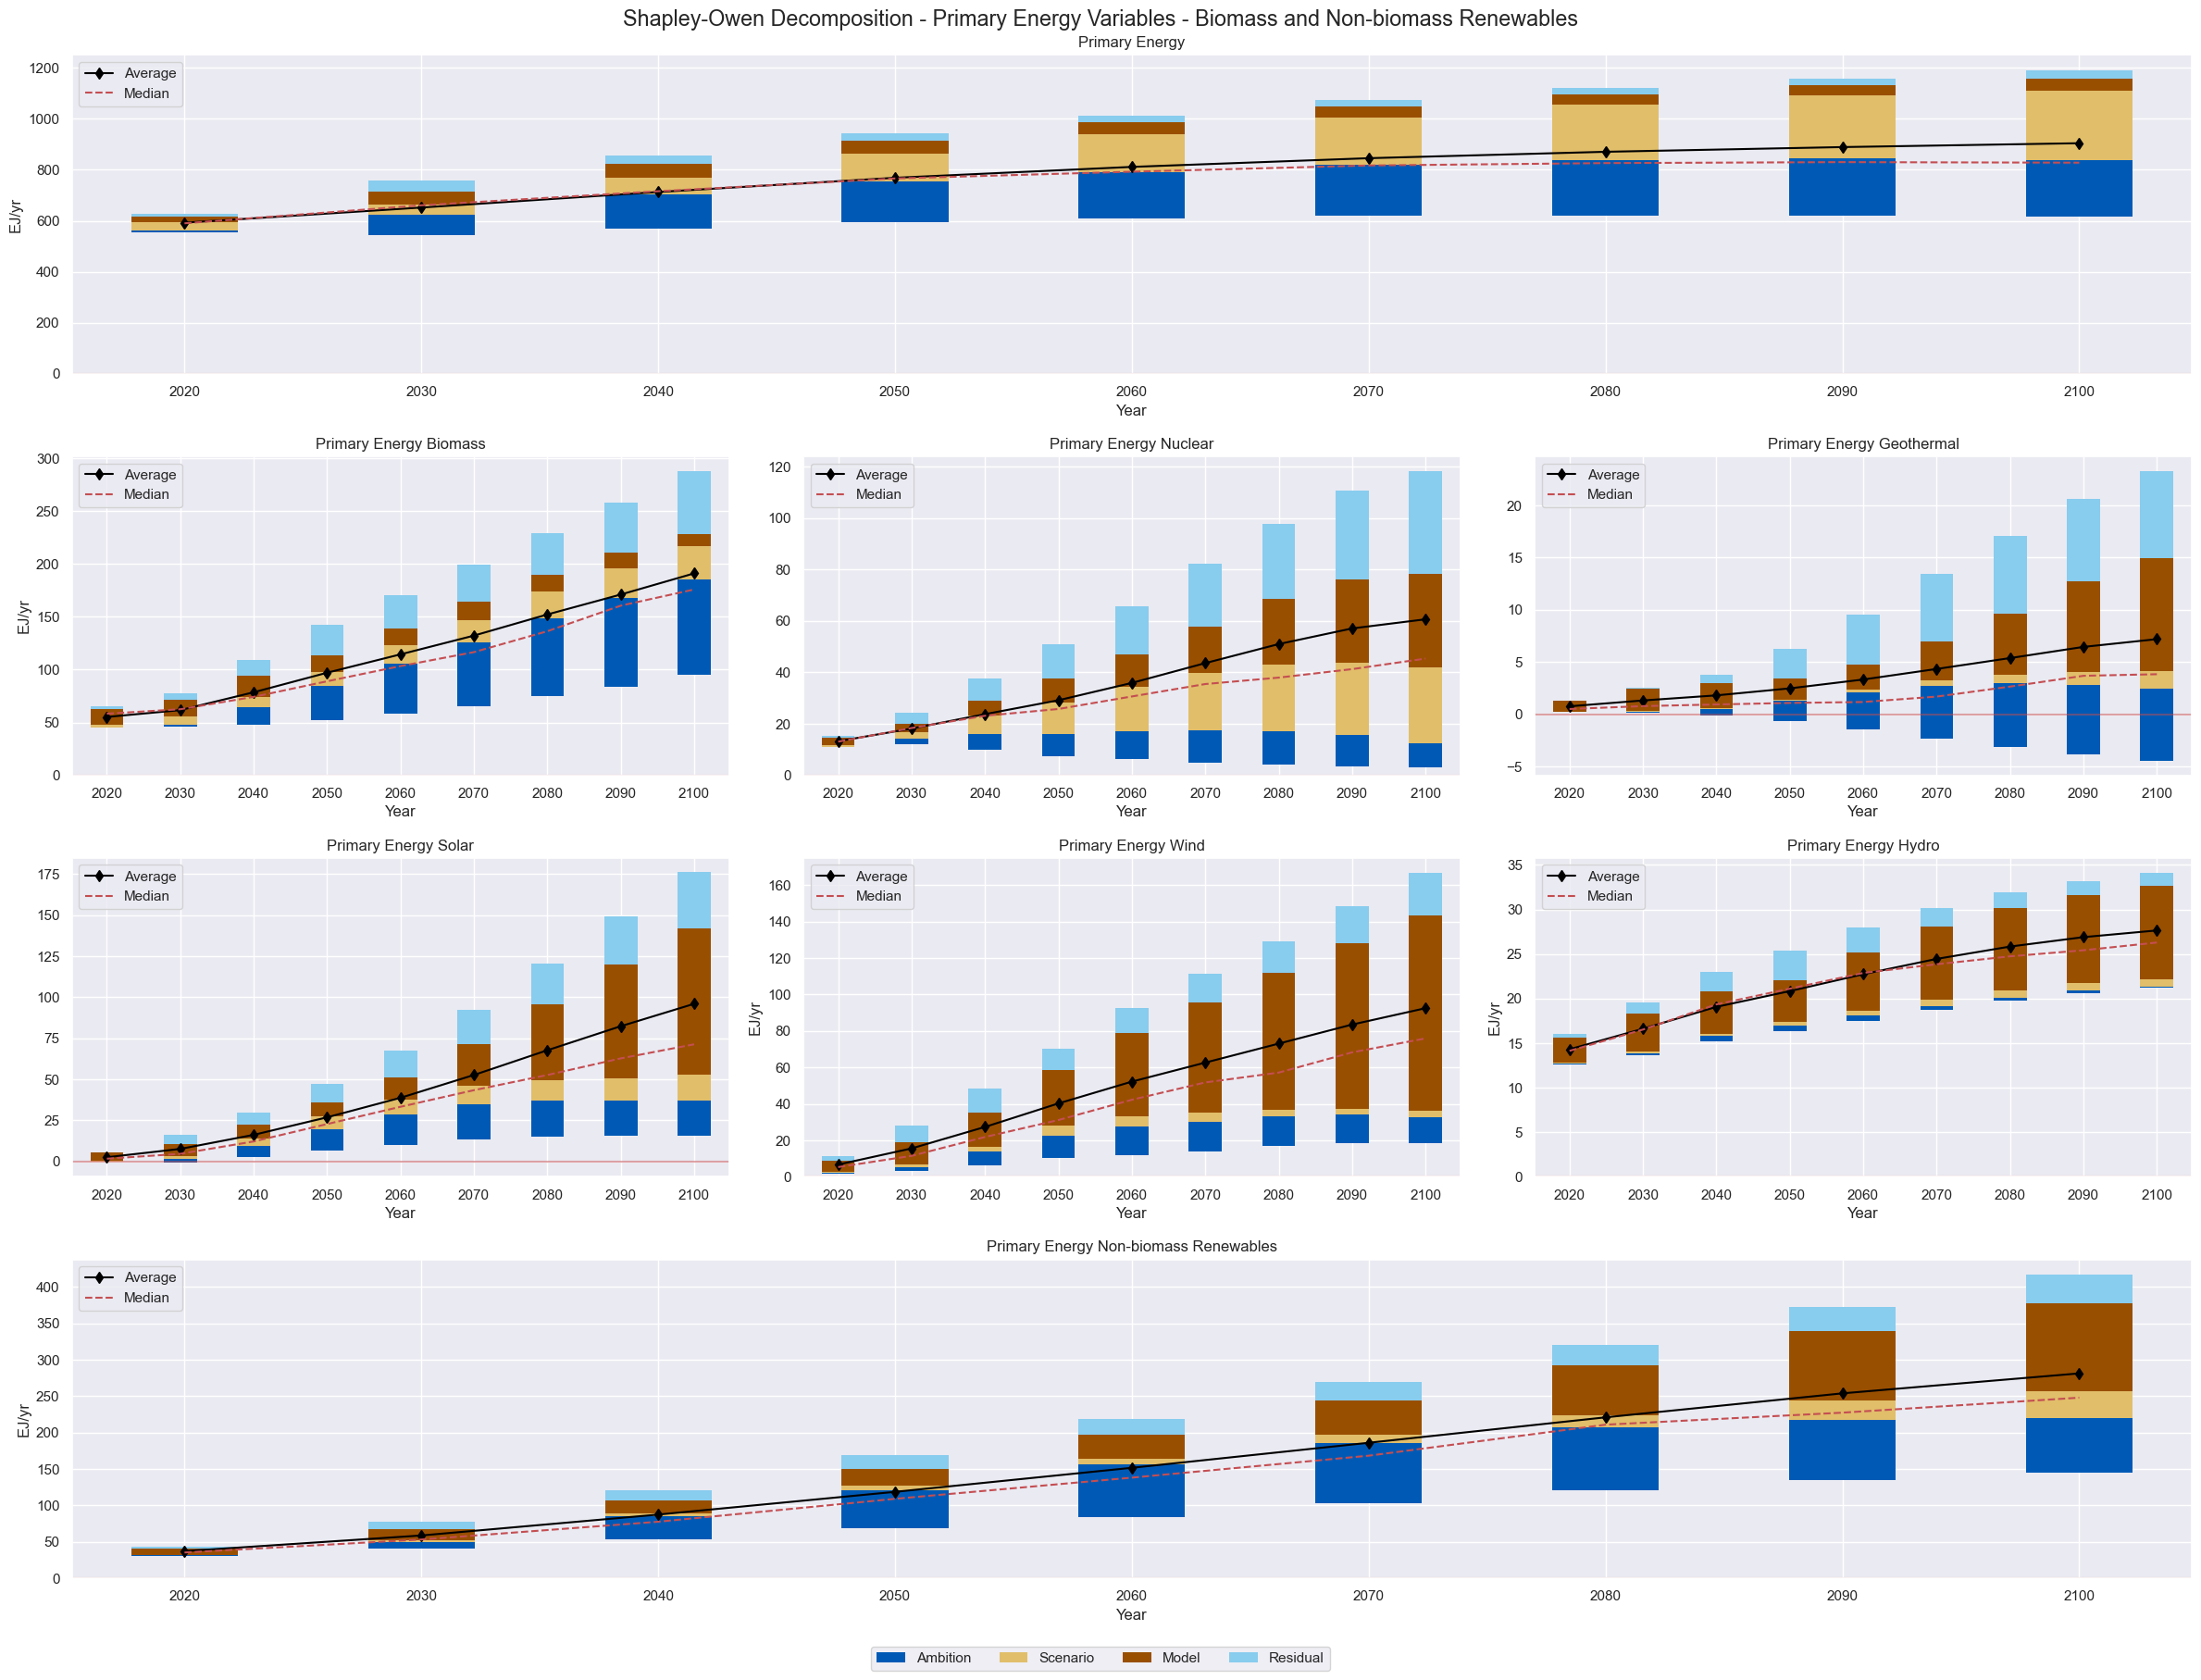

In [57]:
# --------------------------
### Figure 1 replica for slides
# --------------------------

# ----------------------------------
# The dependent variable to plot are
# ----------------------------------
vars = [ 
       'Primary Energy', 
       'Primary Energy Biomass', 
       'Primary Energy Nuclear', 
       'Primary Energy Wind', 
       'Primary Energy Solar', 
       'Primary Energy Hydro',
       'Primary Energy Geothermal', 
       'Primary Energy Non Fossil',
       ]
# -------------------
# Downselect the data
# -------------------
data = df_all[['Year','Variable','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
    'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid',
    'Average','Median']]

# --------------------------
# Set up the style parameters
# --------------------------
sns.set()
sns.set_style("darkgrid")
plt.rcParams['figure.dpi']= 100
plt.rcParams['figure.figsize'] = (13,18)
plt.rc("savefig", dpi=150)
plt.rc("font", size=14)

# -------------------
# Set up the subplots
# -------------------
fig = plt.figure(figsize=(24, 18))  
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1])  

ax0 = fig.add_subplot(gs[0, :])  # Primary Energy spans all columns
ax1 = fig.add_subplot(gs[1, 0])  # PE Biomass
ax3 = fig.add_subplot(gs[1, 1])  # PE Nuclear
ax7 = fig.add_subplot(gs[1, 2])  # PE Geothermal
ax5 = fig.add_subplot(gs[2, 0])  # PE Solar
ax4 = fig.add_subplot(gs[2, 1])  # PE Wind
ax6 = fig.add_subplot(gs[2, 2])  # PE Hydro
ax8 = fig.add_subplot(gs[3, :])  # PE Non Biomass Renewables spans all columns


# ---------------------------------------
# Choose colours for the stacked bar plot
# ---------------------------------------
colours = {
    'Plot_Avg_SD':'#FF000000', # note that the colour here is transparent on purpose
    'Plot_Avg_SD_Surrogate':'#005AB5', # note that the colour here is identical to Plot_Amb below
    'Plot_Amb':'#005AB5', 
    'Plot_Scen':'#E1BE6A', 
    'Plot_Mod':'#994F00', 
    'Plot_Resid':'#88CCEE'    
    }

# ----------------------------------------------------
# First Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax0, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy', 
    legend=None,
    )

# Legends for the stacked bar plot. 
# Note that the legend for Avg_SD and its surrogate is hidden using "_" before the legend name 
# This section is only needed in the top panel 
labels = ['_Plot_Avg_SD','_Plot_Avg_SD_Surrogate',
    'Ambition','Scenario','Model','Residual']
fig.legend(
            labels, 
            loc = 'center', 
            bbox_to_anchor=(0.5,-0.01), ncol=4
            )

# Add horizontal line for 0 y-axis value, should appear where needed
ax0.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax0, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax0, 
        label=None
        )

ax0.set(
    ylabel=y_axis
    )


# ----------------------------------------------------
# Second Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Biomass'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax1, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Biomass',  
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax1.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax1, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax1, 
        )

ax1.set(  
    ylabel=y_axis,
    )


# ----------------------------------------------------
# Third Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Nuclear'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax3, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Nuclear', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax3.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax3, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax3, 
        )

# ----------------------------------------------------
# Fourth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Wind'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax4, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Wind', 
    legend=None,

    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax4.axhline(0,color="r", alpha = 0.5, linestyle = "-") # to do: change the ax

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax4, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax4, 
        )

ax4.set(          
    ylabel=y_axis
    )

# ----------------------------------------------------
# Fifth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Solar'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax5, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Solar', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax5.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax5, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax5, 
        )

# ----------------------------------------------------
# Sixth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Hydro'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax6, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Hydro', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax6.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax6, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax6, 
        )

ax6.set(        
    ylabel=y_axis
    )

# ----------------------------------------------------
# Seventh Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Geothermal'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax7,
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Geothermal', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax7.axhline(0,color="r", alpha = 0.5, linestyle = "-")

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax7, 
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax7,
        )


# ----------------------------------------------------
# Eighth Panel
# ----------------------------------------------------

# Inputs to the code
variable = 'Primary Energy Non Biomass Renewables'
y_axis = 'EJ/yr'

# The stacked bar plot for the Shapley Decomposition
data.query('Variable == @variable')\
[['Year','Plot_Avg_SD','Plot_Avg_SD_Surrogate',
'Plot_Amb','Plot_Scen','Plot_Mod','Plot_Resid']].\
    set_index('Year').\
    plot(
    kind='bar',
    ax=ax8, 
    stacked=True, 
    color=colours,
    edgecolor = "none",
    width=0.45,
    title='Primary Energy Non-biomass Renewables', 
    legend=None,
    )

# Add horizontal line for 0 y-axis value, should appear where needed
ax8.axhline(0,color="r", alpha = 0.5, linestyle = "-") 

# The line plot for the Average
data.query('Variable == @variable')\
    [['Average']].\
    plot(
        kind='line', 
        marker = 'd', 
        color='black',
        ax=ax8, 
        label=None
        )

# The line plot for the Median
data.query('Variable == @variable')\
    [['Median']].\
    plot(
        kind='line', 
        linestyle='--', 
        color='r',
        ax=ax8, 
        label=None
        )

ax8.set(      
    ylabel=y_axis
    )



# -------------------
# Overall plot params
# -------------------

fig.suptitle('Shapley-Owen Decomposition - Primary Energy Variables - Biomass and Non-biomass Renewables') # to do: change the title
fig.tight_layout()
plt.show() 

warnings.filterwarnings('ignore')

# Save the plot as Figure 1
fig.savefig('Figure_1_Slides.png', bbox_inches='tight')